# Unresolved Binary Analysis Using Photometric Data
**DESCRIPTION** This project is meant to experiment as to whether a mixture of isochrone models fit using an Expectation-Maximization Algorithm can sufficiently capture the fraction of unresolved binaries in an open cluster like the Pleiades Cluster.

Let's first start with our normal import statements. Make sure that while running the Jupyter notebook, you are selected to the `iso_env` kernel that you created earlier with the `./install.sh` script.

In [34]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from analyzer import GaiaAnalyzer, TESSAnalyzer
from analyzer import MISTFitter, BinaryMixtureFitter
from downloader import LightCurveExtractor
from generator import IsochroneSynthesizer

from utils import bootstrap_mixture_weights

%load_ext autoreload
%autoreload 2

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The command below just applies some neat formatting to the table for graphs.

In [2]:
# some statements to make the figures look nicer 
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 10, 
                     'ytick.labelsize': 10,
                     'axes.labelsize': 12,
                    
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6)
                    })

### Part 1: Single-Star Isochrone Fitting

To get started, let's first get Gaia data from the Pleiades. Membership was determined in a paper that is linked [here](https://arxiv.org/abs/2110.03837v1) and was already predownloaded in the `pleiades_downloader.ipynb` notebook. If you notice, there appears to be a distinct "single" isochrone track with a second thinner one to its right at approximately ~0.75 magnitudes higher, which aligns with intuition.

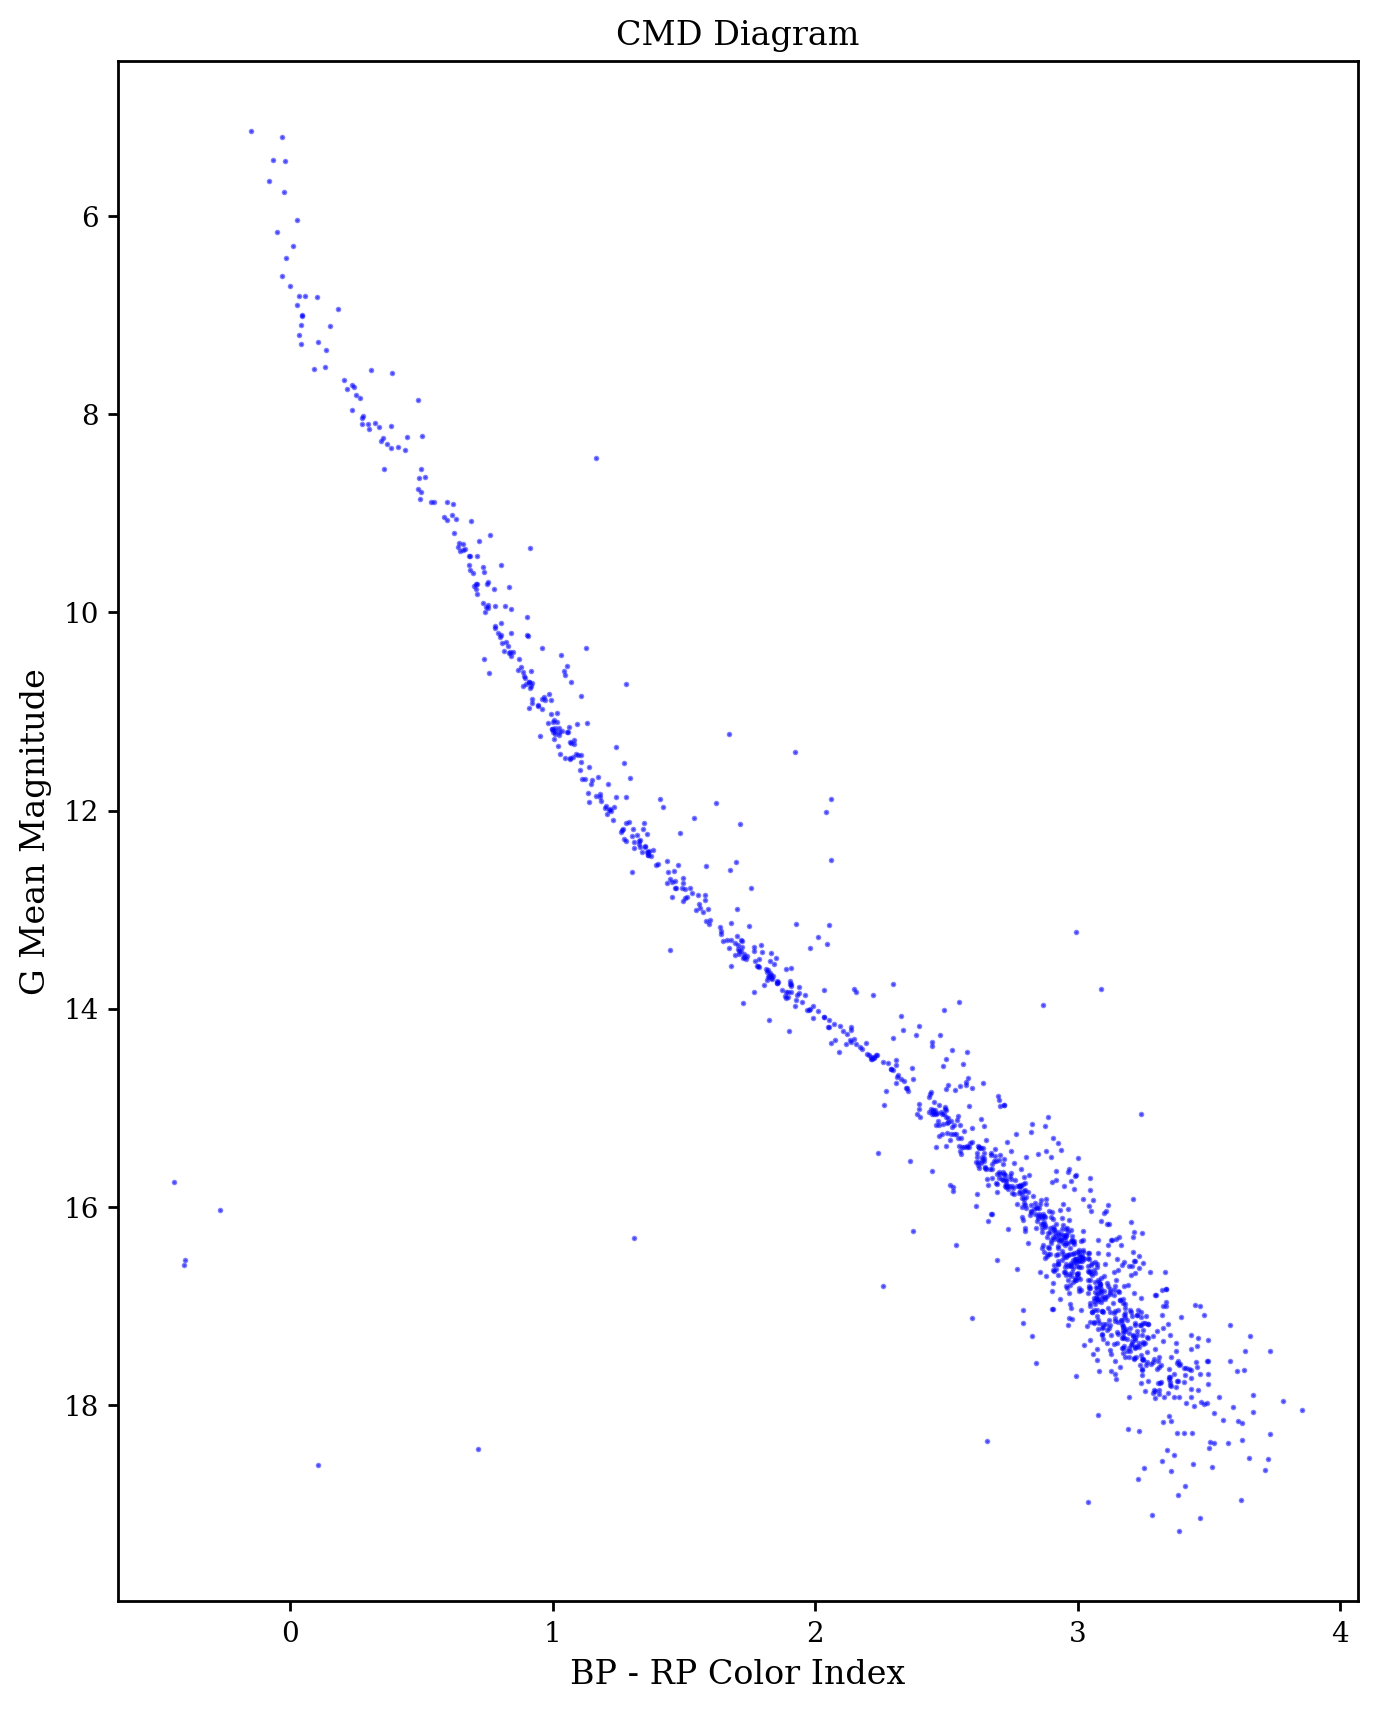

(<Figure size 800x1000 with 1 Axes>,
 <Axes: title={'center': 'CMD Diagram'}, xlabel='BP - RP Color Index', ylabel='G Mean Magnitude'>)

In [3]:
# Downloading Gaia data.
gaia_analyzer = GaiaAnalyzer(filename='data/gaia.csv')
gaia_analyzer.get_data()

# Displaying Gaia data.
df = gaia_analyzer.get_data().copy()
gaia_analyzer.plot_hr_diagram(show=True)

This is a nice CMD already! Now, let's fit a single-star evolution track isochrone to this now. To achieve this, we do a custom MCMC fit using a grid of MIST isochrones supplied in the `isochrones` package.

100%|██████████| 2000/2000 [16:57<00:00,  1.97it/s]  
2025-11-17 16:40:43,788 - WARNING - Too few points to create valid contours
2025-11-17 16:40:43,838 - WARNING - Too few points to create valid contours
2025-11-17 16:40:43,902 - WARNING - Too few points to create valid contours
2025-11-17 16:40:43,979 - WARNING - Too few points to create valid contours


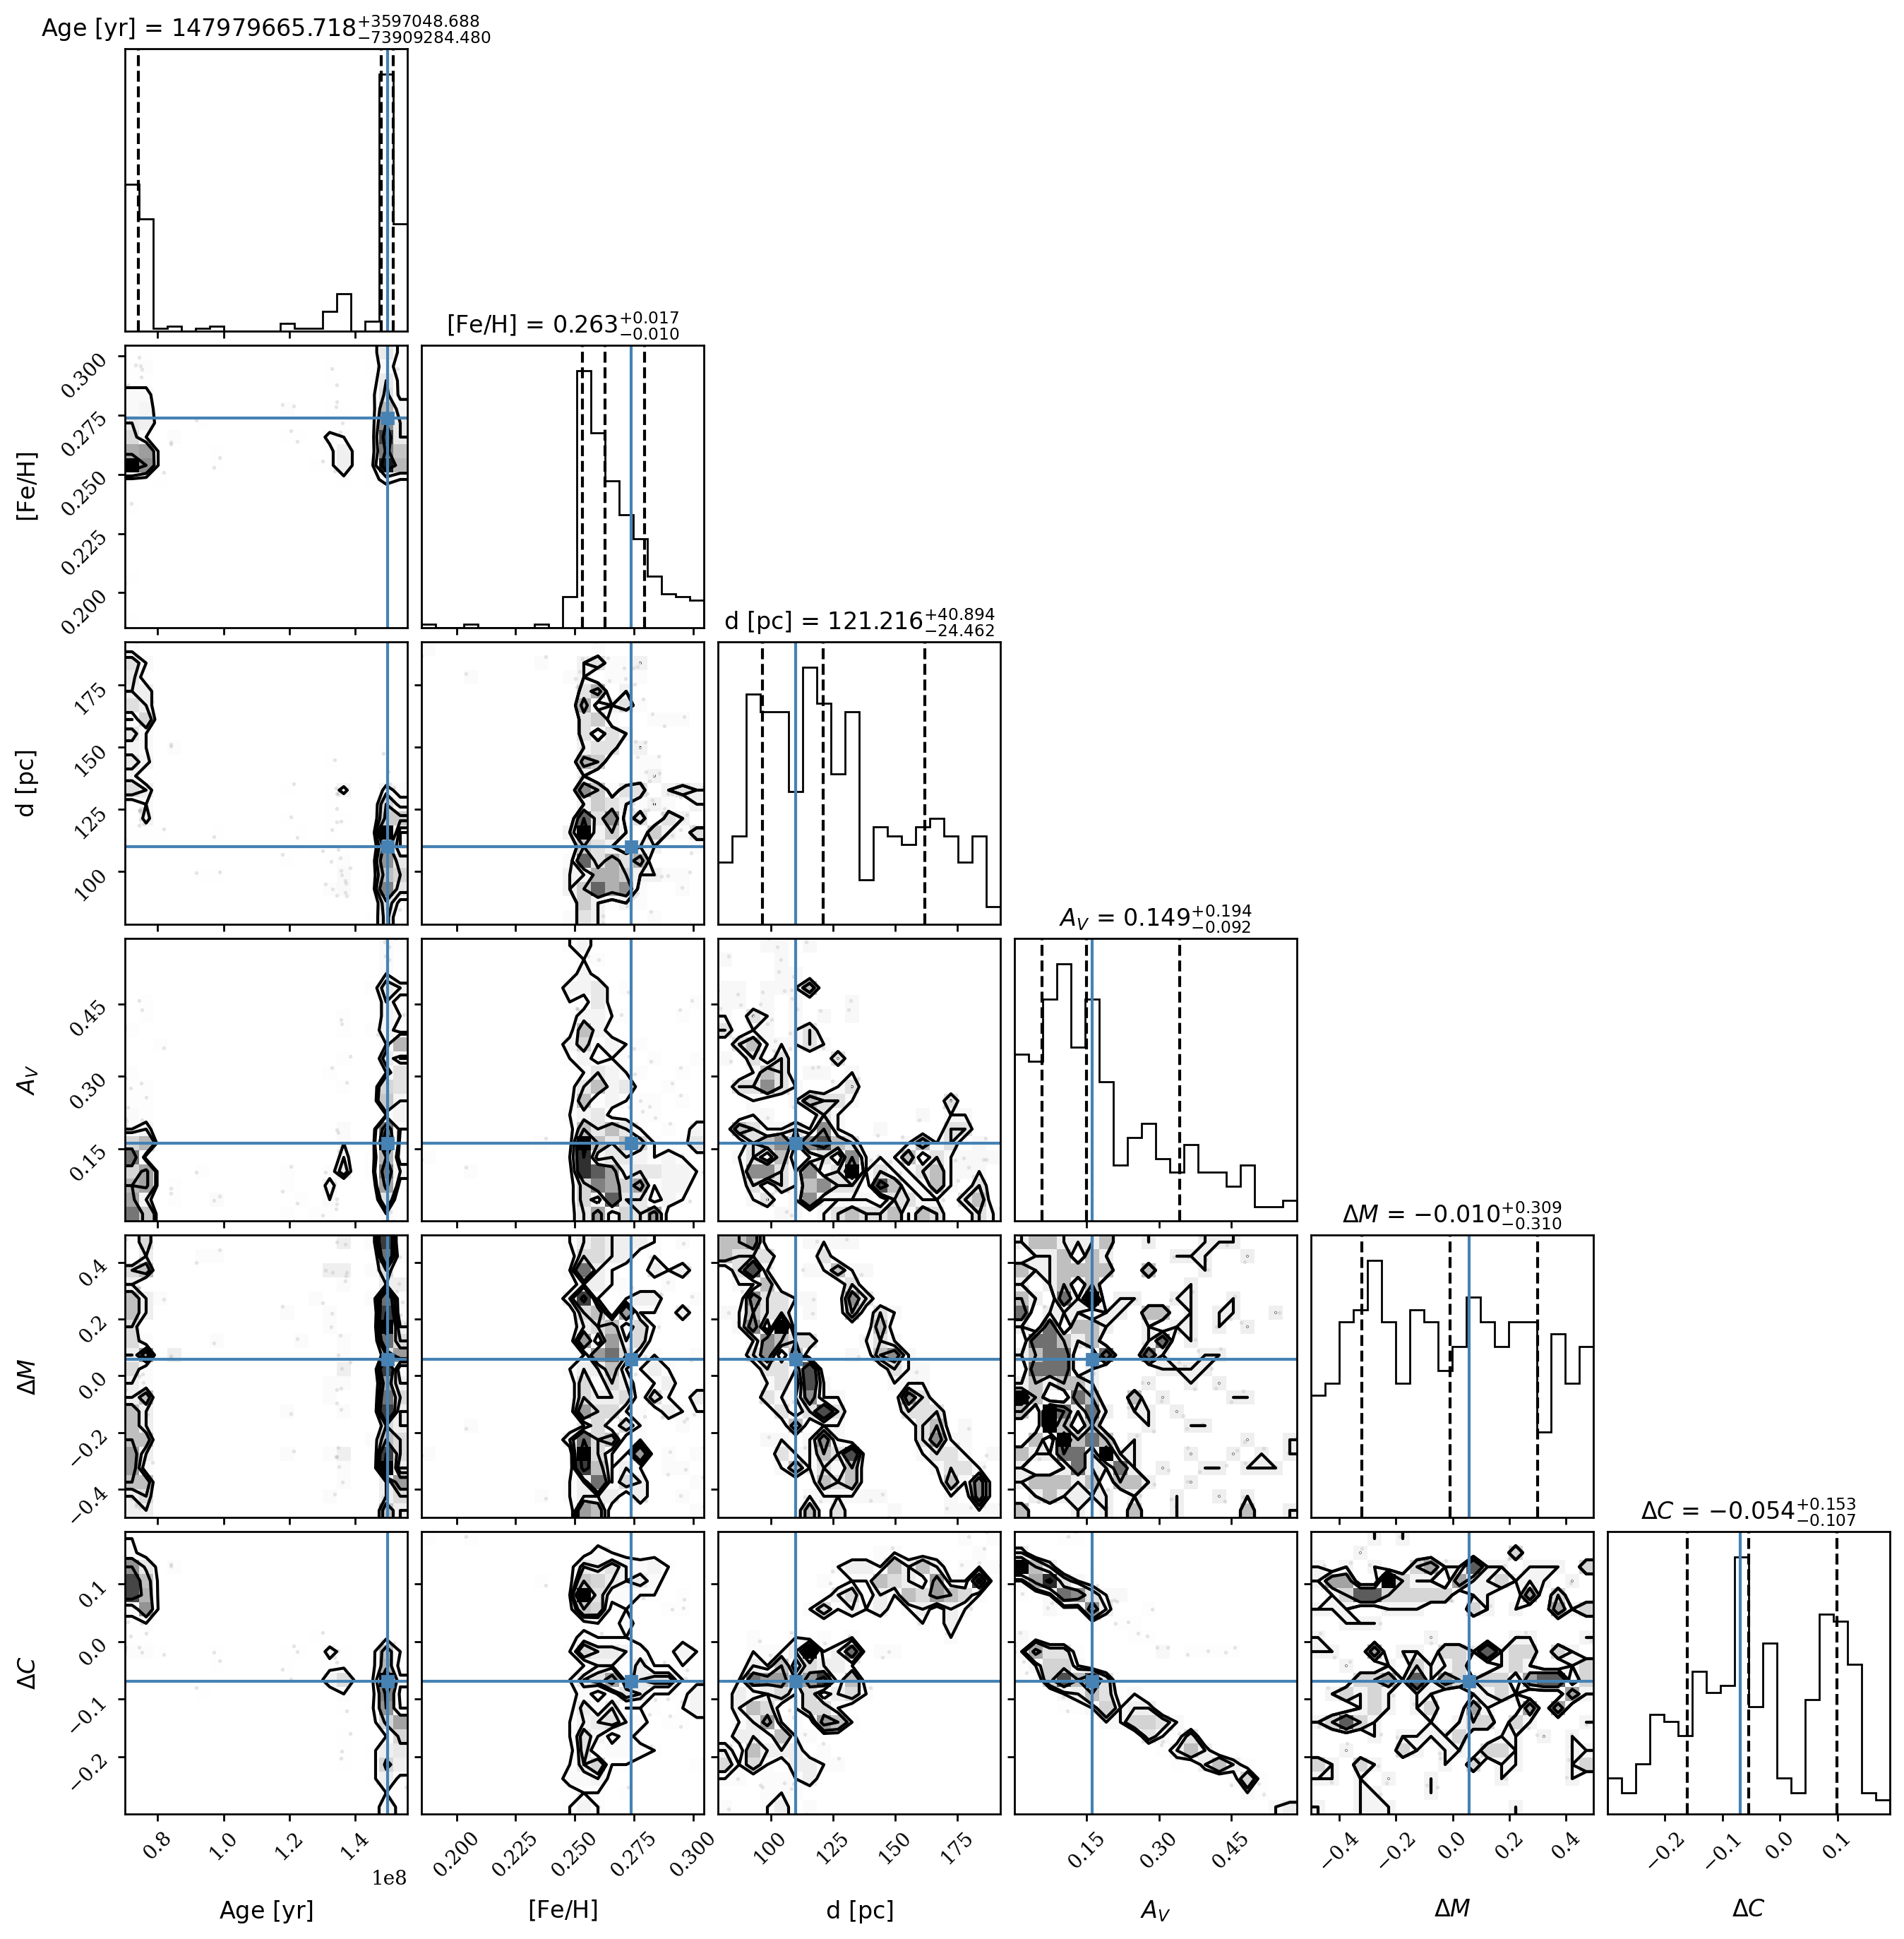

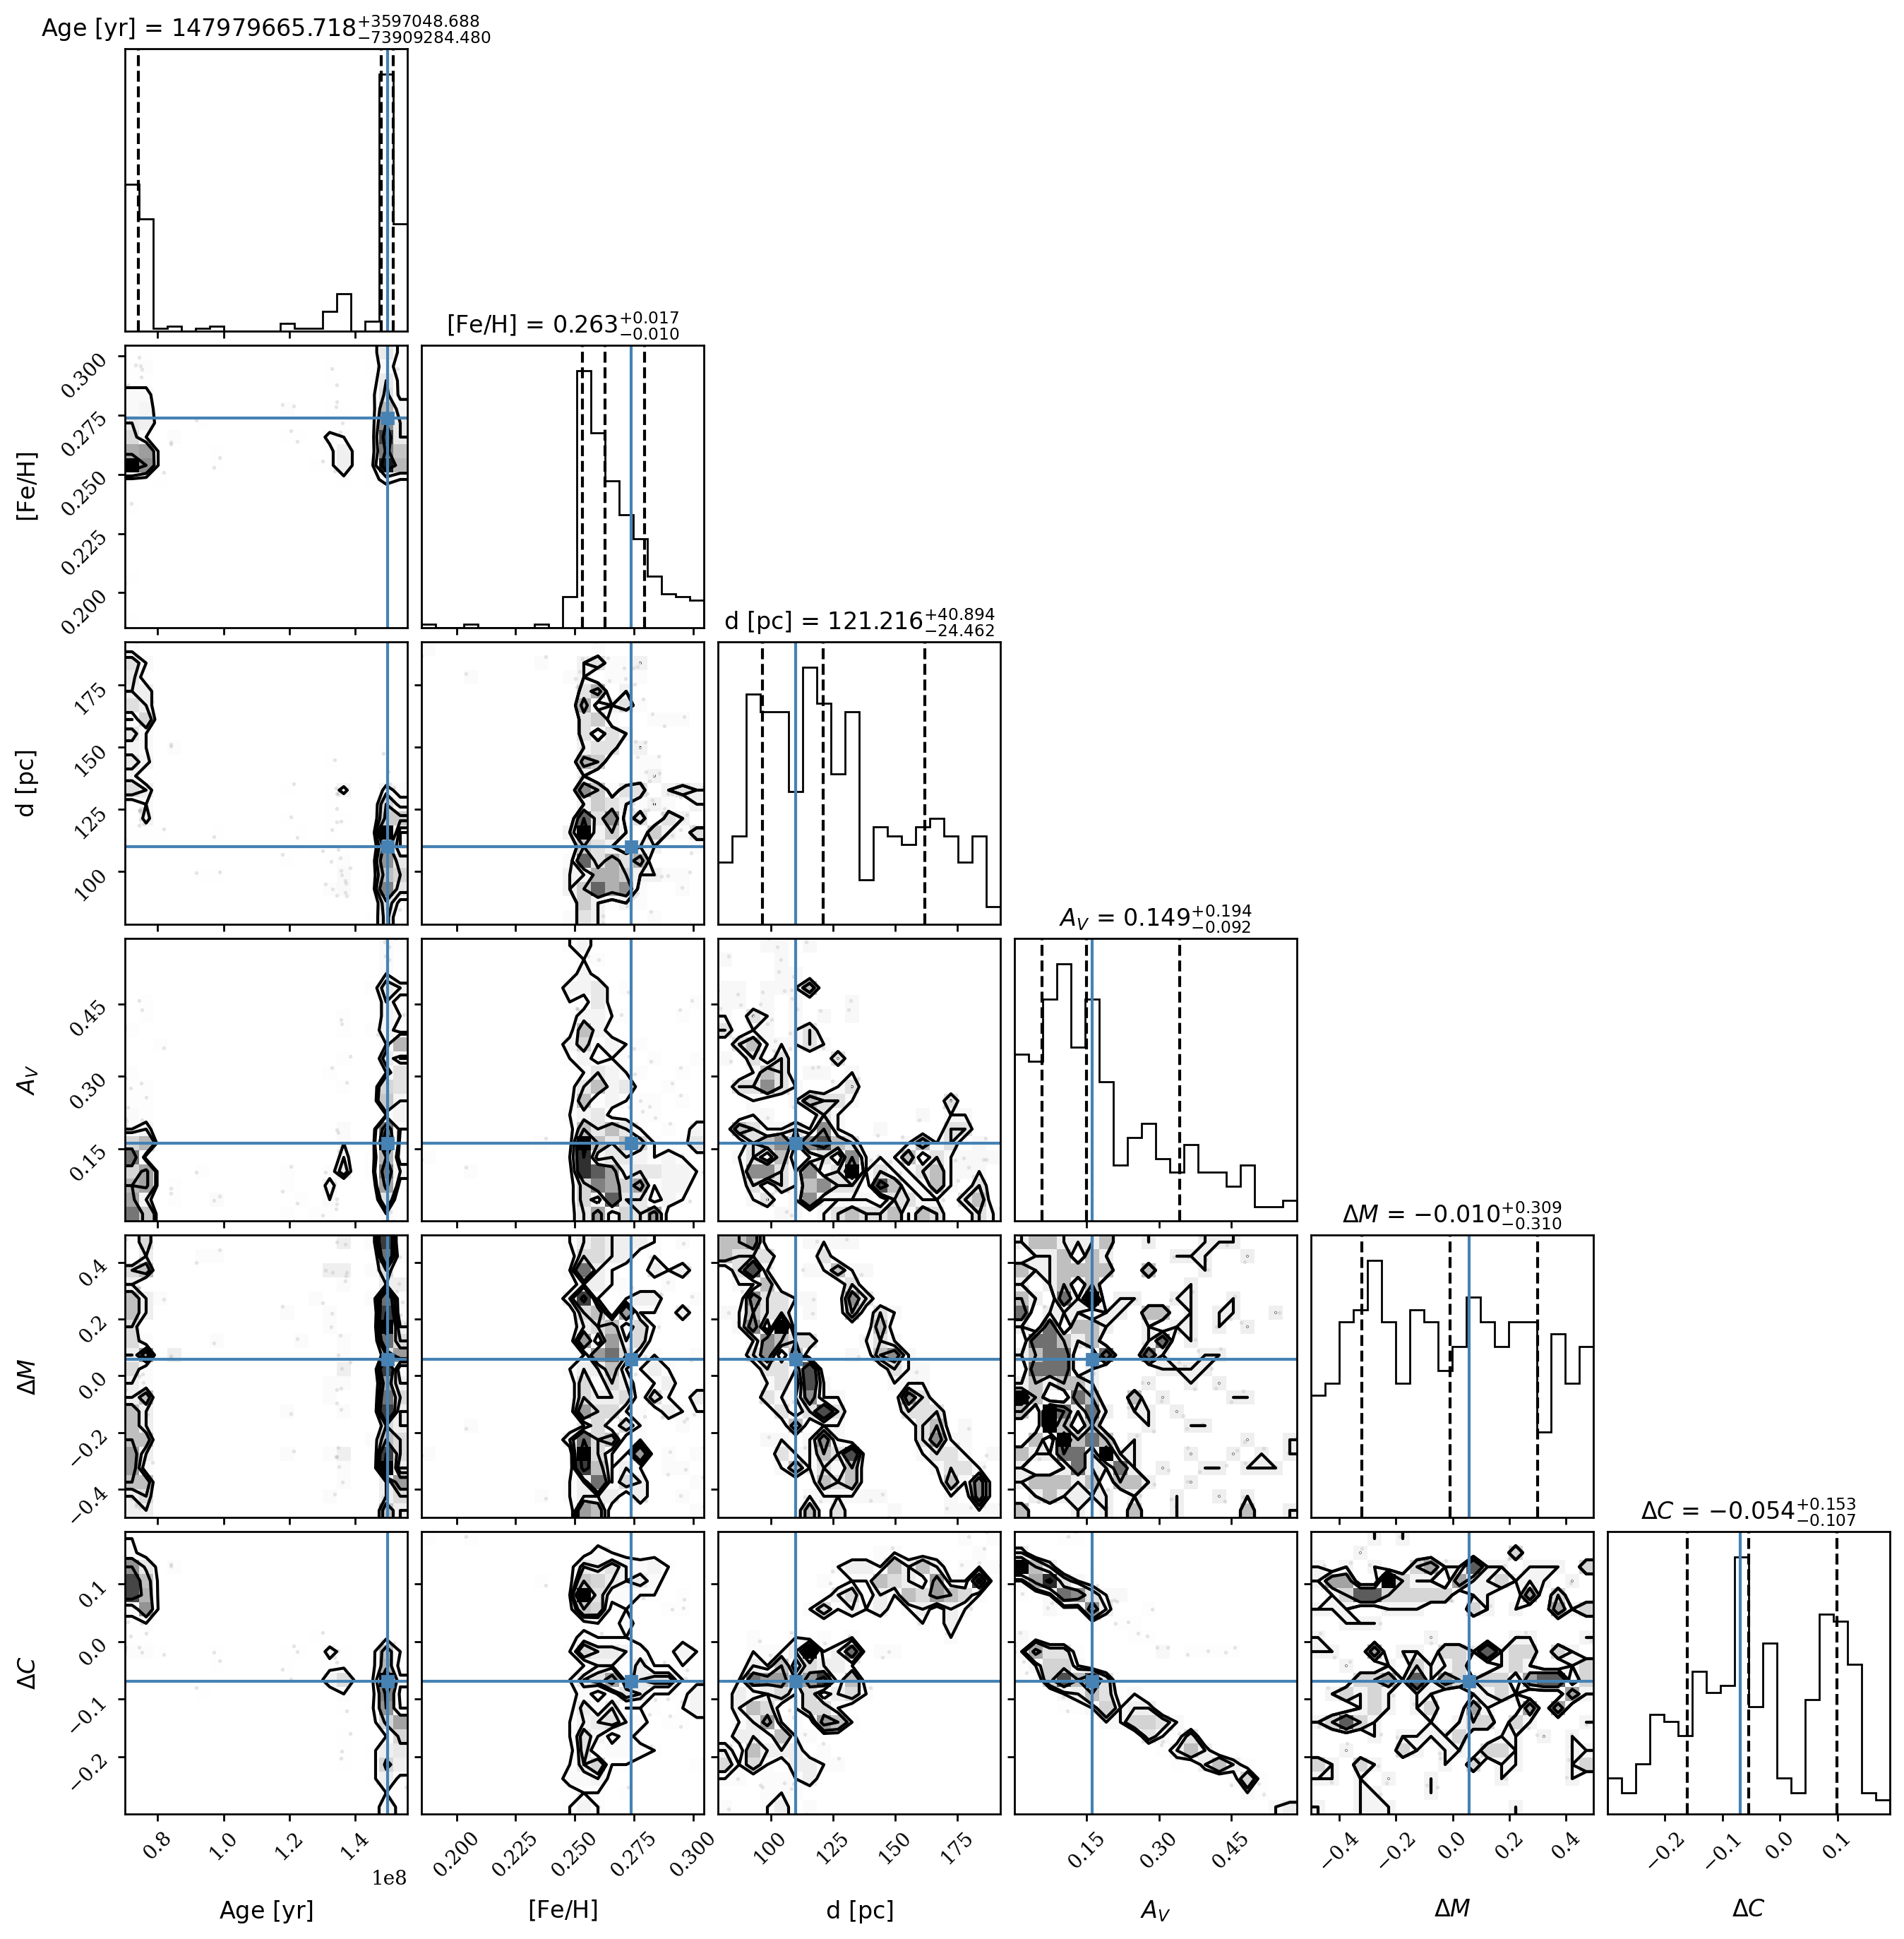

In [4]:
# Let's start with a nice simple MCMC.
fitter = MISTFitter(data=df, age_range=(70e6, 160e6))
sampler = fitter.sample_cluster(n_walkers=32, n_burn=200, n_steps=2000)

# Let's display the corner plot now!
fitter.plot_corner(sampler, discard=200, thin=200)

In 2009, a re-analyses of data from the European Hipparcos mission, a satellite designed to measure stellar distances, announced that the true distance to the Pleiades was only 395 light-years with a 1% uncertainty, so our estimate is fairly close!

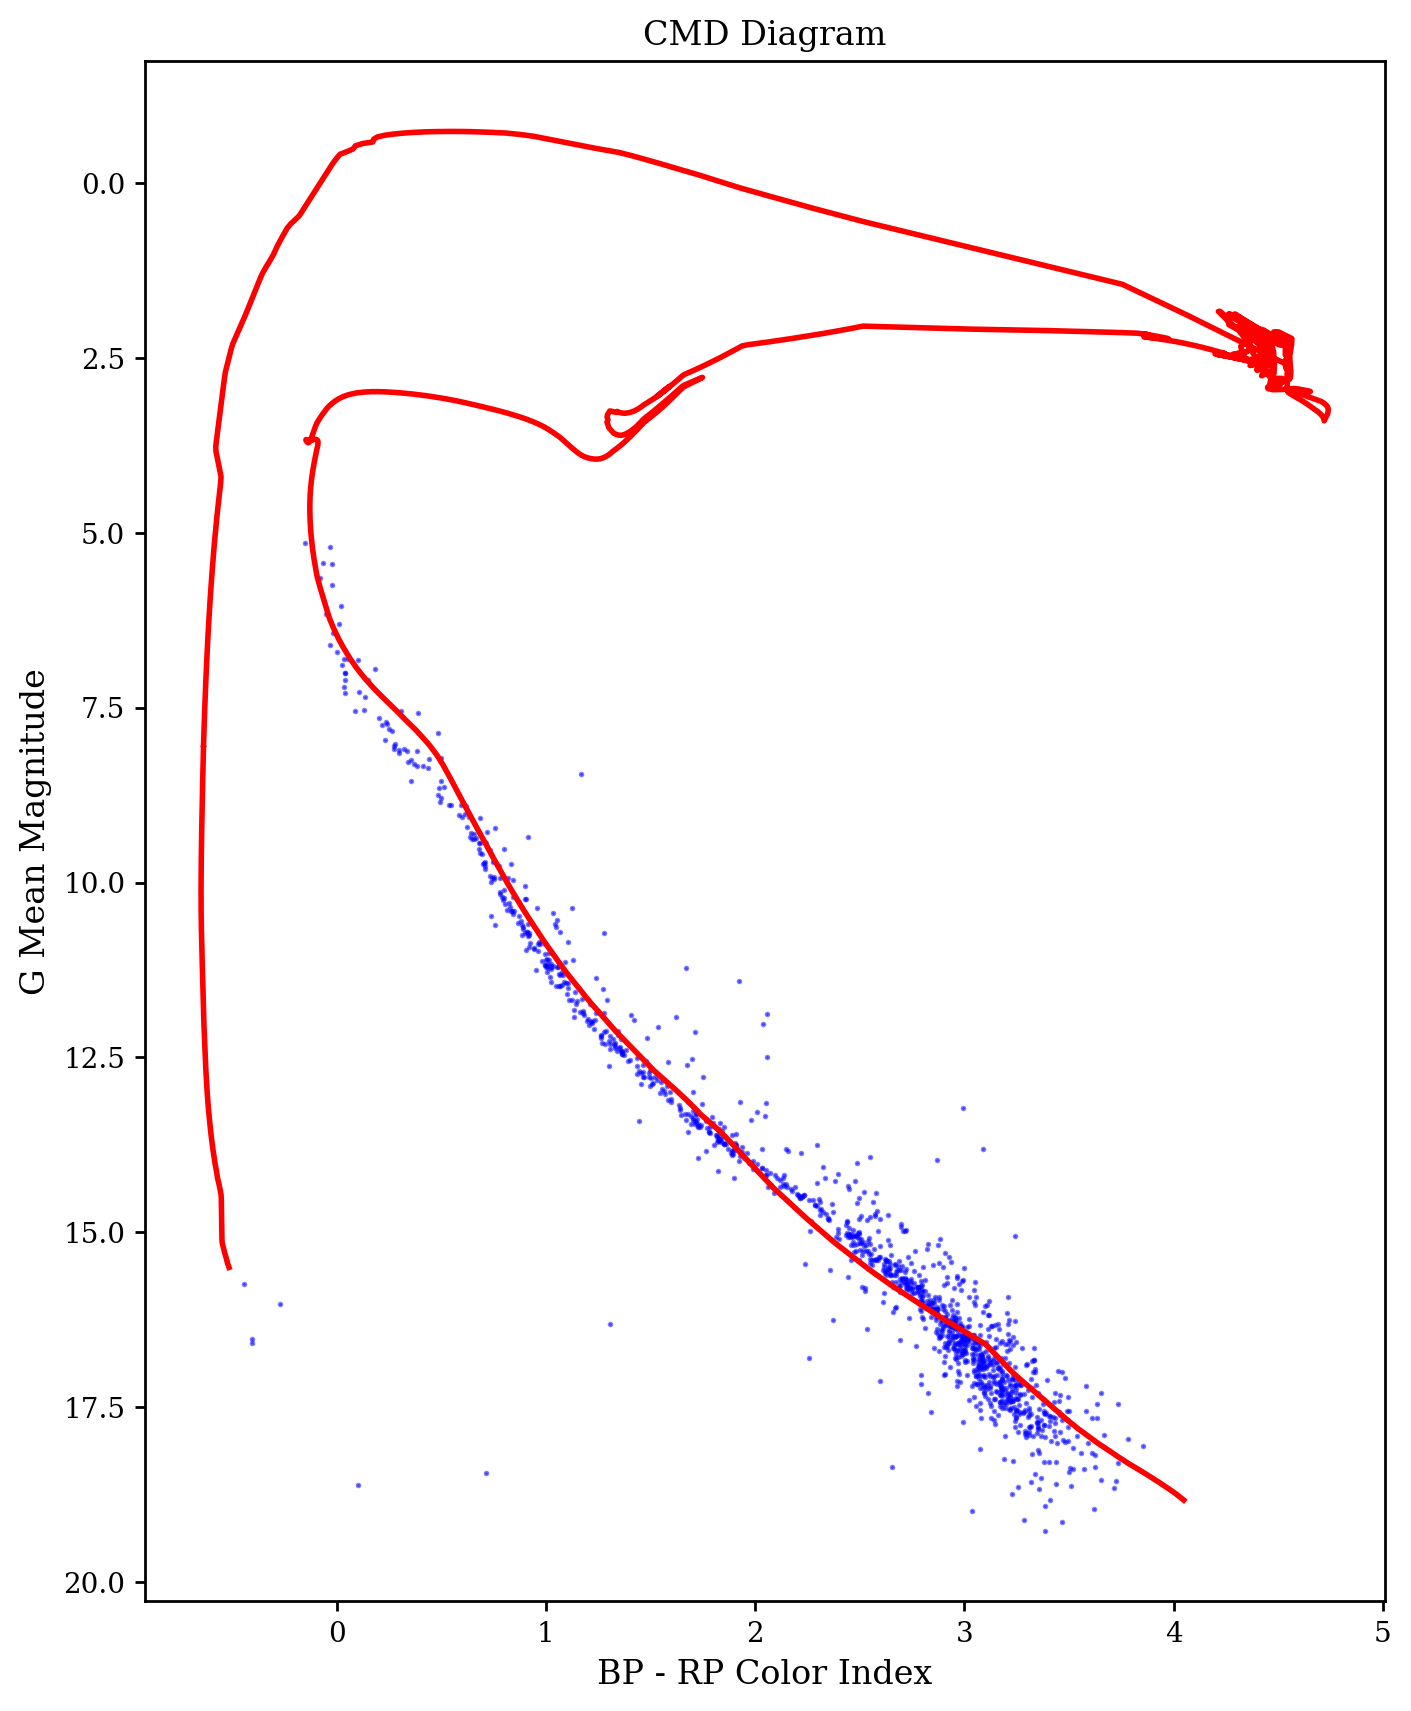

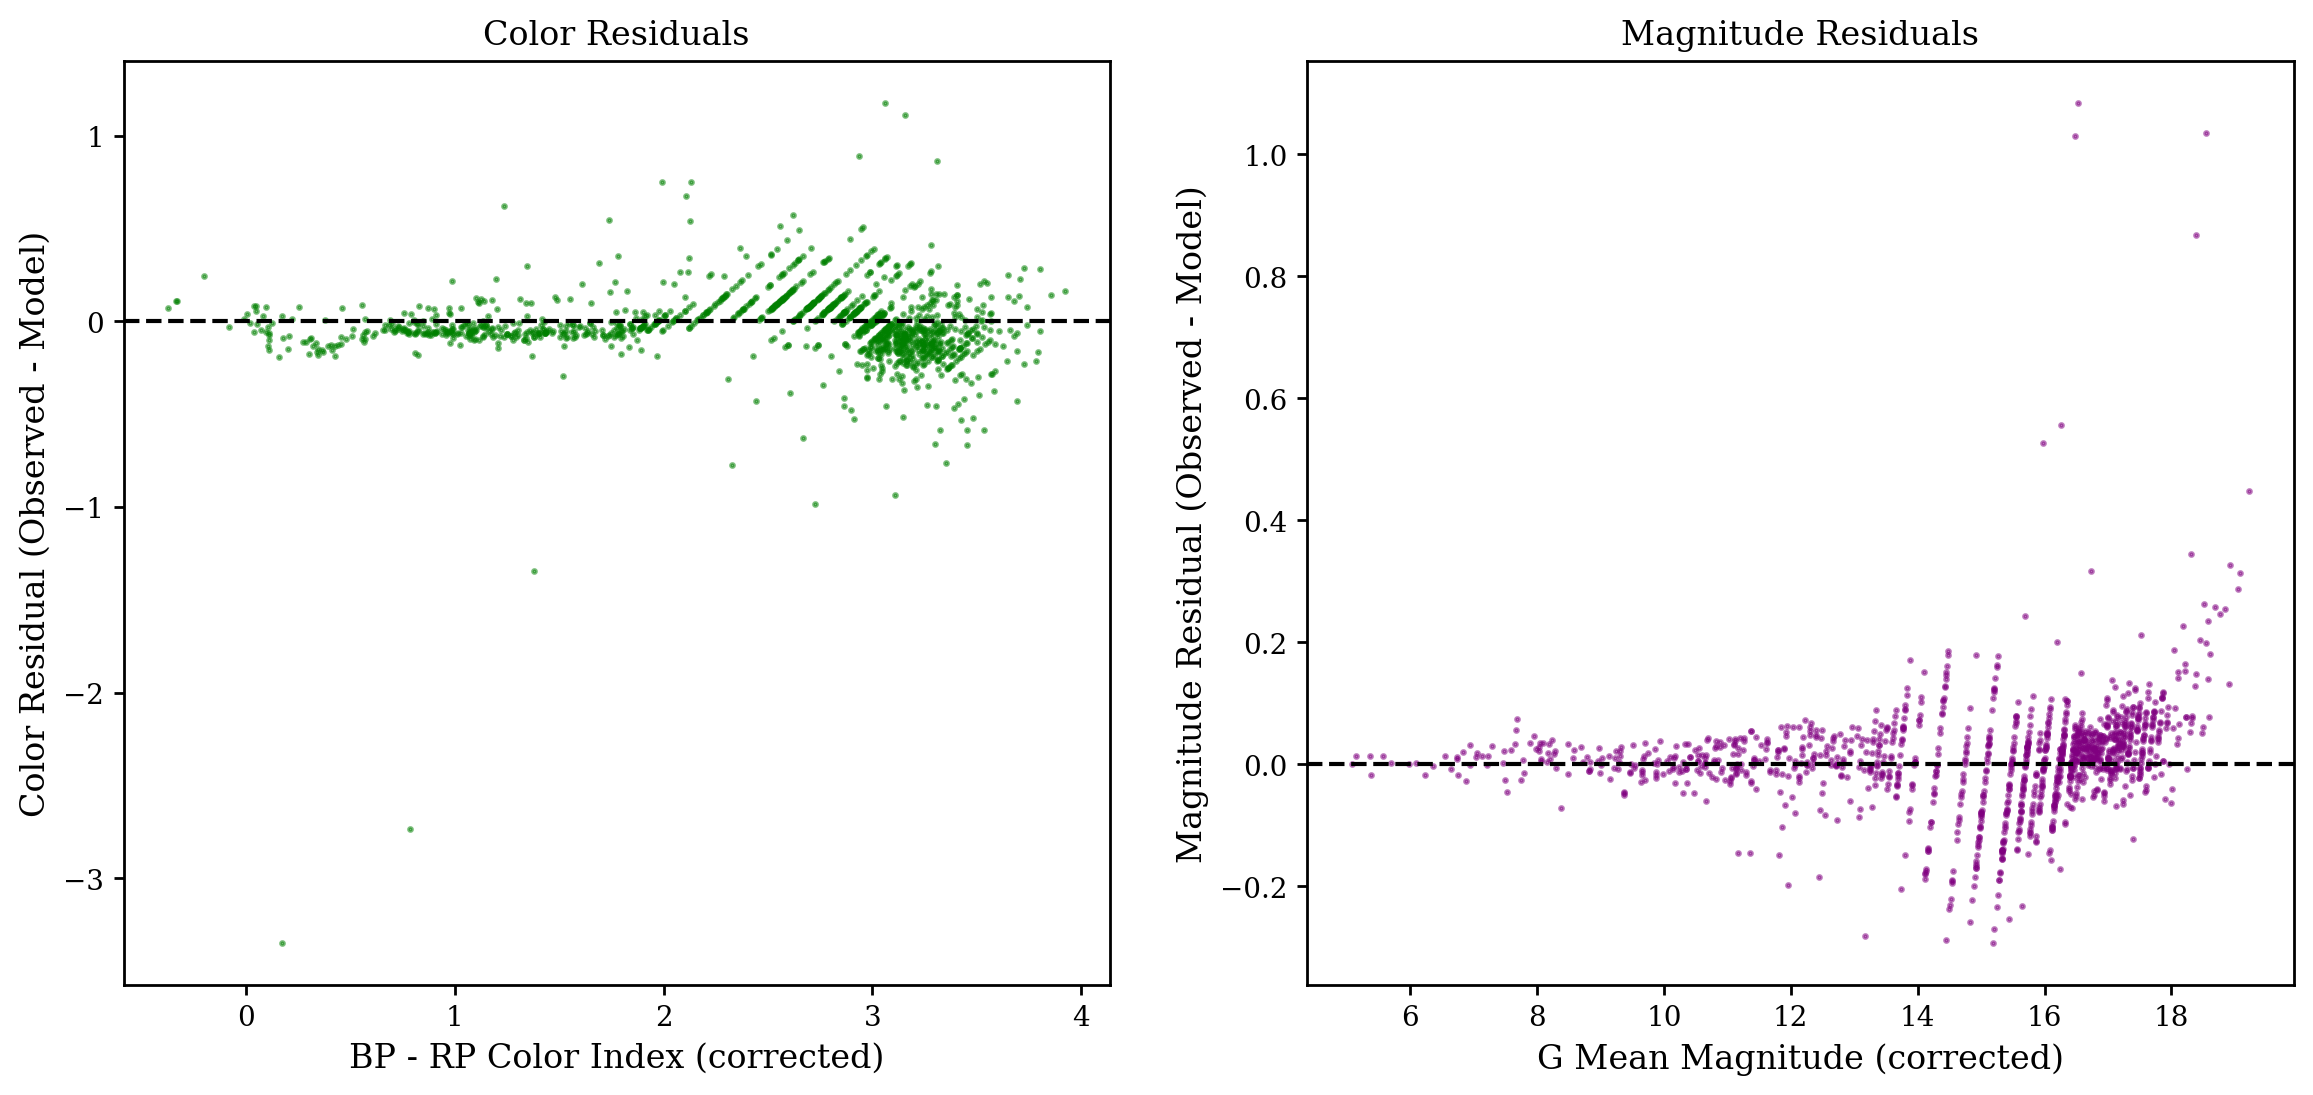

2025-11-17 16:40:46,481 - INFO - Best cluster parameters:
Age=1.50e+08 yr, [Fe/H]=0.27, Distance=110.2 pc, A_V=0.16


In [5]:
# Now, we can extract the best parameters of the model and also plot residuals.
best_params = fitter.get_best_model()
fitter.plot_isochrone(best_params)
fitter.plot_residuals(theta=best_params)

logging.info(f"Best cluster parameters:\nAge={best_params[0]:.2e} yr, [Fe/H]={best_params[1]:.2f}, "
      f"Distance={best_params[2]:.1f} pc, A_V={best_params[3]:.2f}")

Like in Lab 3 for the Rotation Curve analysis, we can actually plot many possible isochrones at once that comply with the $-\chi^2$ cutoff we've chosen.

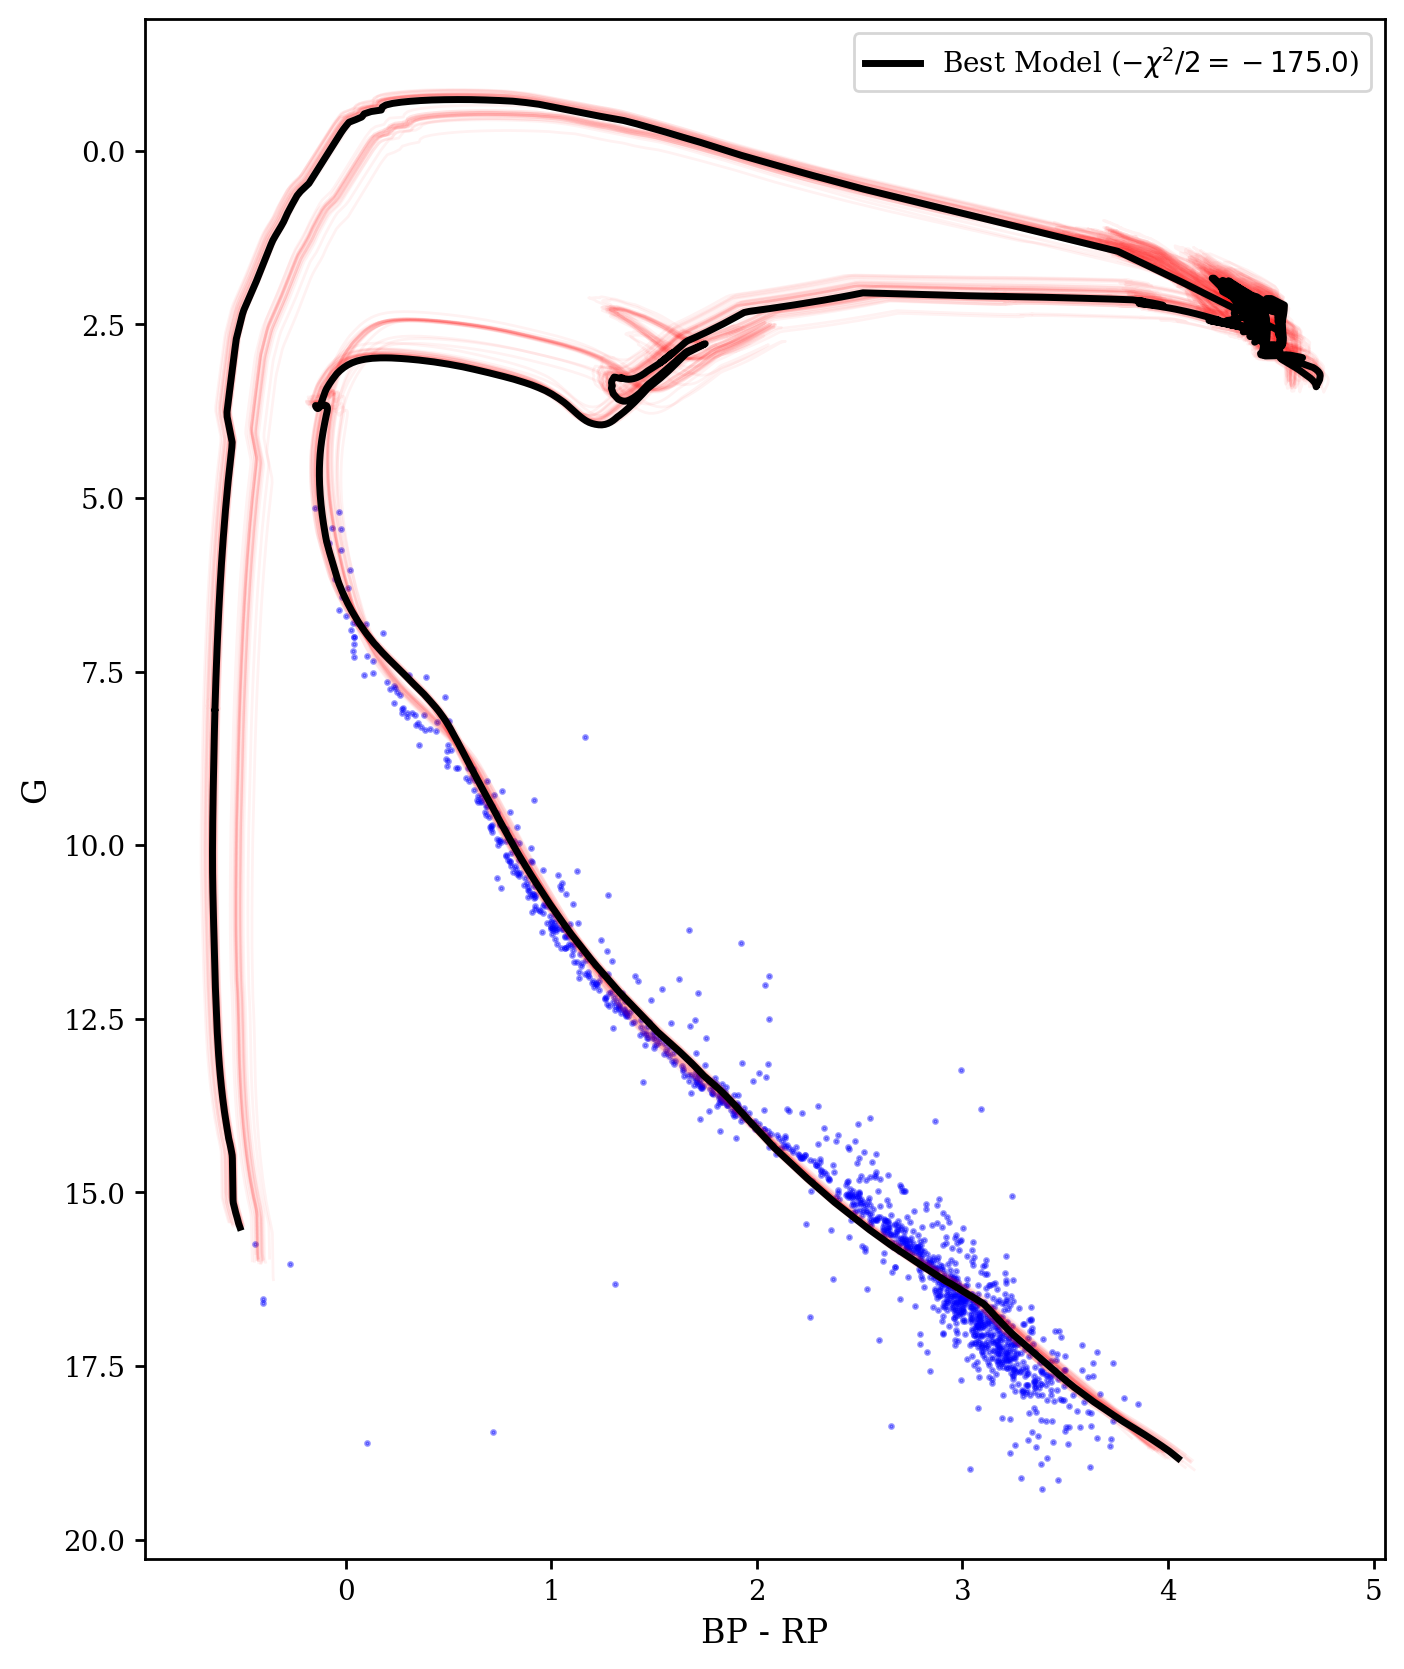

(<Figure size 800x1000 with 1 Axes>, <Axes: xlabel='BP - RP', ylabel='G'>)

In [6]:
# Pretty plotting of many proposal isochrones.
fitter.plot_good_isochrones(chi2_cutoff=1)

We can also get the Bayesian Information Criterion (BIC) just like Lab 4 to evaluate the strength of our model.

In [7]:
fitter.bic()

392.8091416954008

### Part 2: Binary Mixture Model
​We construct a binary isochrone by adding the fluxes of a primary star and a hypothetical companion, and use a mixture model that looks like:
$$
    p(c_i, m_i \mid \theta) = \sum_{k \in \{\text{single, binary, field}\}} \pi_k p_k(c_i, m_i \mid \theta)
$$
where $\pi_k$ is the mixture weight for the probability density function $p_k$ and the parameters
$$
    \theta = (\text{age, [Fe/H], $d$, $A_V$, $\Delta M$, $\Delta C$})
$$
See https://iopscience.iop.org/article/10.3847/1538-3881/ac47a3/pdf.

In [35]:
# Use the previous single star isochrone fit as a prior to inform the binary mixture fit.
binary_fitter = BinaryMixtureFitter(data=df, tau=1.6)
binary_fitter.fit(theta=fitter.get_best_model())

logging.info(f"The optimal fit weights are: [f_single, f_binary, f_field] = {binary_fitter.get_mixture_weights()}")

2025-11-17 17:18:51,430 - INFO - Starting EM fit
2025-11-17 17:18:51,431 - INFO - Initial weights: [0.8 0.2 0. ]
100%|██████████| 40/40 [00:04<00:00,  8.20it/s]
2025-11-17 17:18:56,311 - INFO - Final mixture weights: [0.29072573 0.24134668 0.46792759]
2025-11-17 17:18:56,312 - INFO - The optimal fit weights are: [f_single, f_binary, f_field] = [0.29072573 0.24134668 0.46792759]


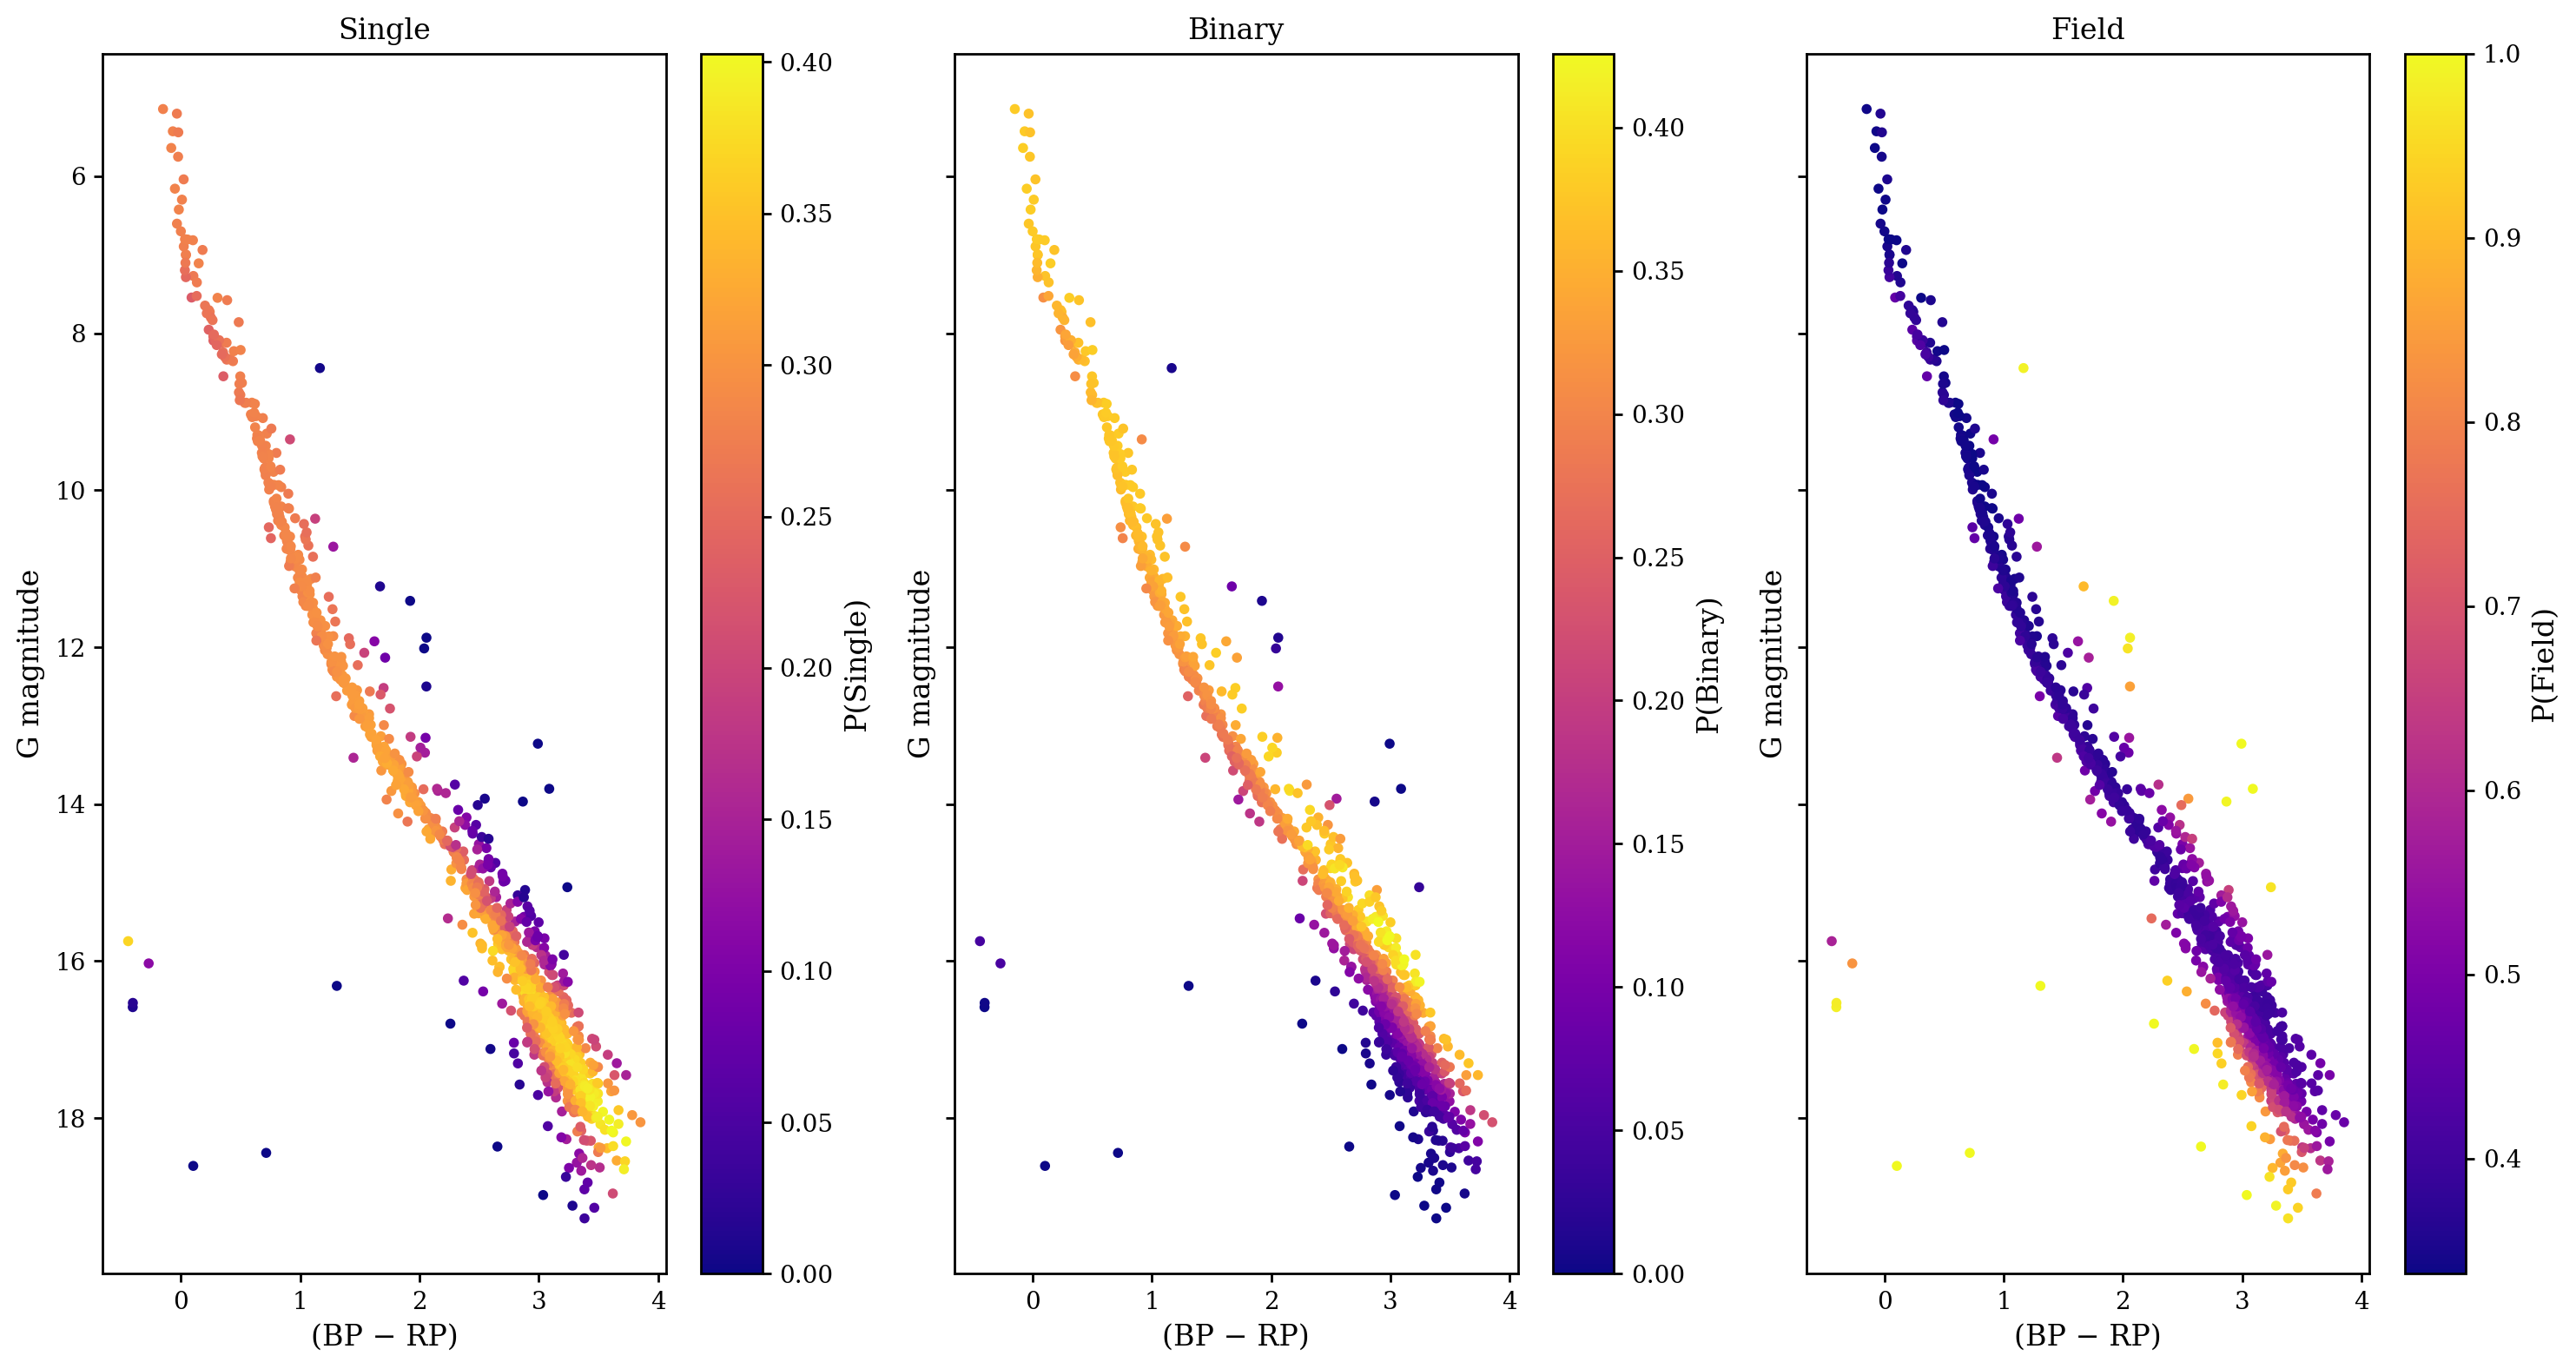

(<Figure size 1500x800 with 6 Axes>,
 array([<Axes: title={'center': 'Single'}, xlabel='(BP − RP)', ylabel='G magnitude'>,
        <Axes: title={'center': 'Binary'}, xlabel='(BP − RP)', ylabel='G magnitude'>,
        <Axes: title={'center': 'Field'}, xlabel='(BP − RP)', ylabel='G magnitude'>],
       dtype=object))

In [36]:
# Let's see the probability distribution for each star now.
binary_fitter.plot()

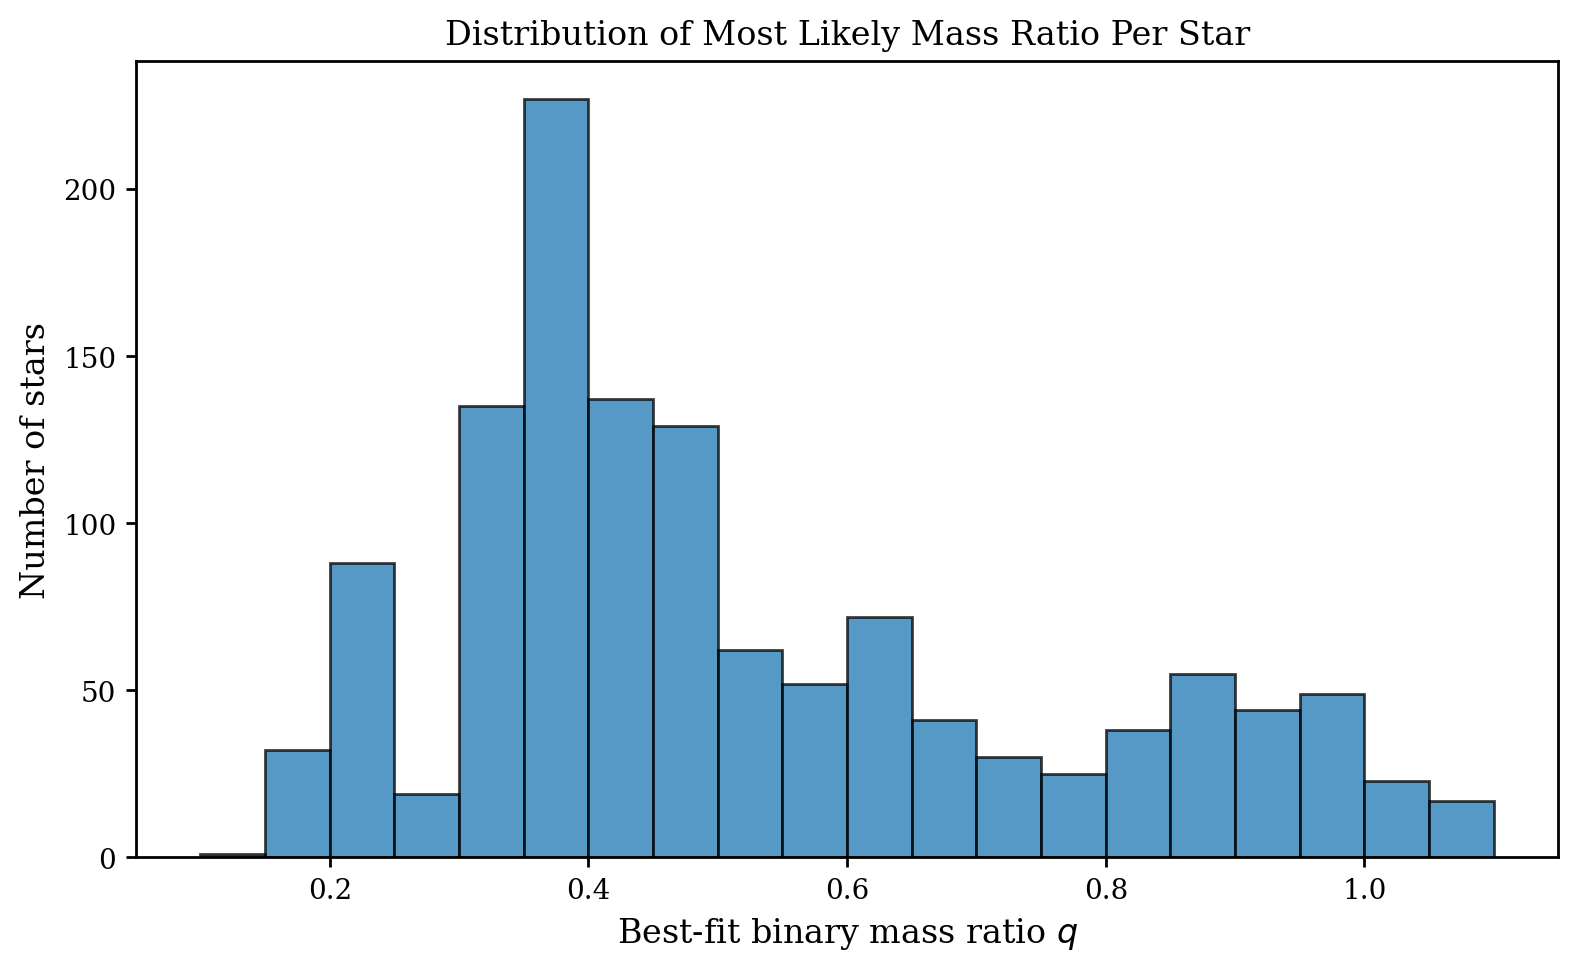

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Most Likely Mass Ratio Per Star'}, xlabel='Best-fit binary mass ratio $q$', ylabel='Number of stars'>)

In [37]:
# We can also get the preedicted mass ratios, q, per star.
binary_fitter.plot_qs()

Let's see what happens now if we REMOVE the field component.

In [42]:
# Use the previous single star isochrone fit as a prior to inform the binary mixture fit.
fieldless_fitter = BinaryMixtureFitter(data=df, use_field=False)
fieldless_fitter.fit(theta=fitter.get_best_model())

logging.info(f"The optimal fit weights are: [f_single, f_binary] = {fieldless_fitter.get_mixture_weights()}")

2025-11-17 17:22:01,765 - INFO - Starting EM fit
2025-11-17 17:22:01,766 - INFO - Initial weights: [0.8 0.2]
100%|██████████| 40/40 [00:04<00:00,  8.48it/s]
2025-11-17 17:22:06,487 - INFO - Final mixture weights: [0.57816572 0.42183428]
2025-11-17 17:22:06,488 - INFO - The optimal fit weights are: [f_single, f_binary] = [0.57816572 0.42183428]


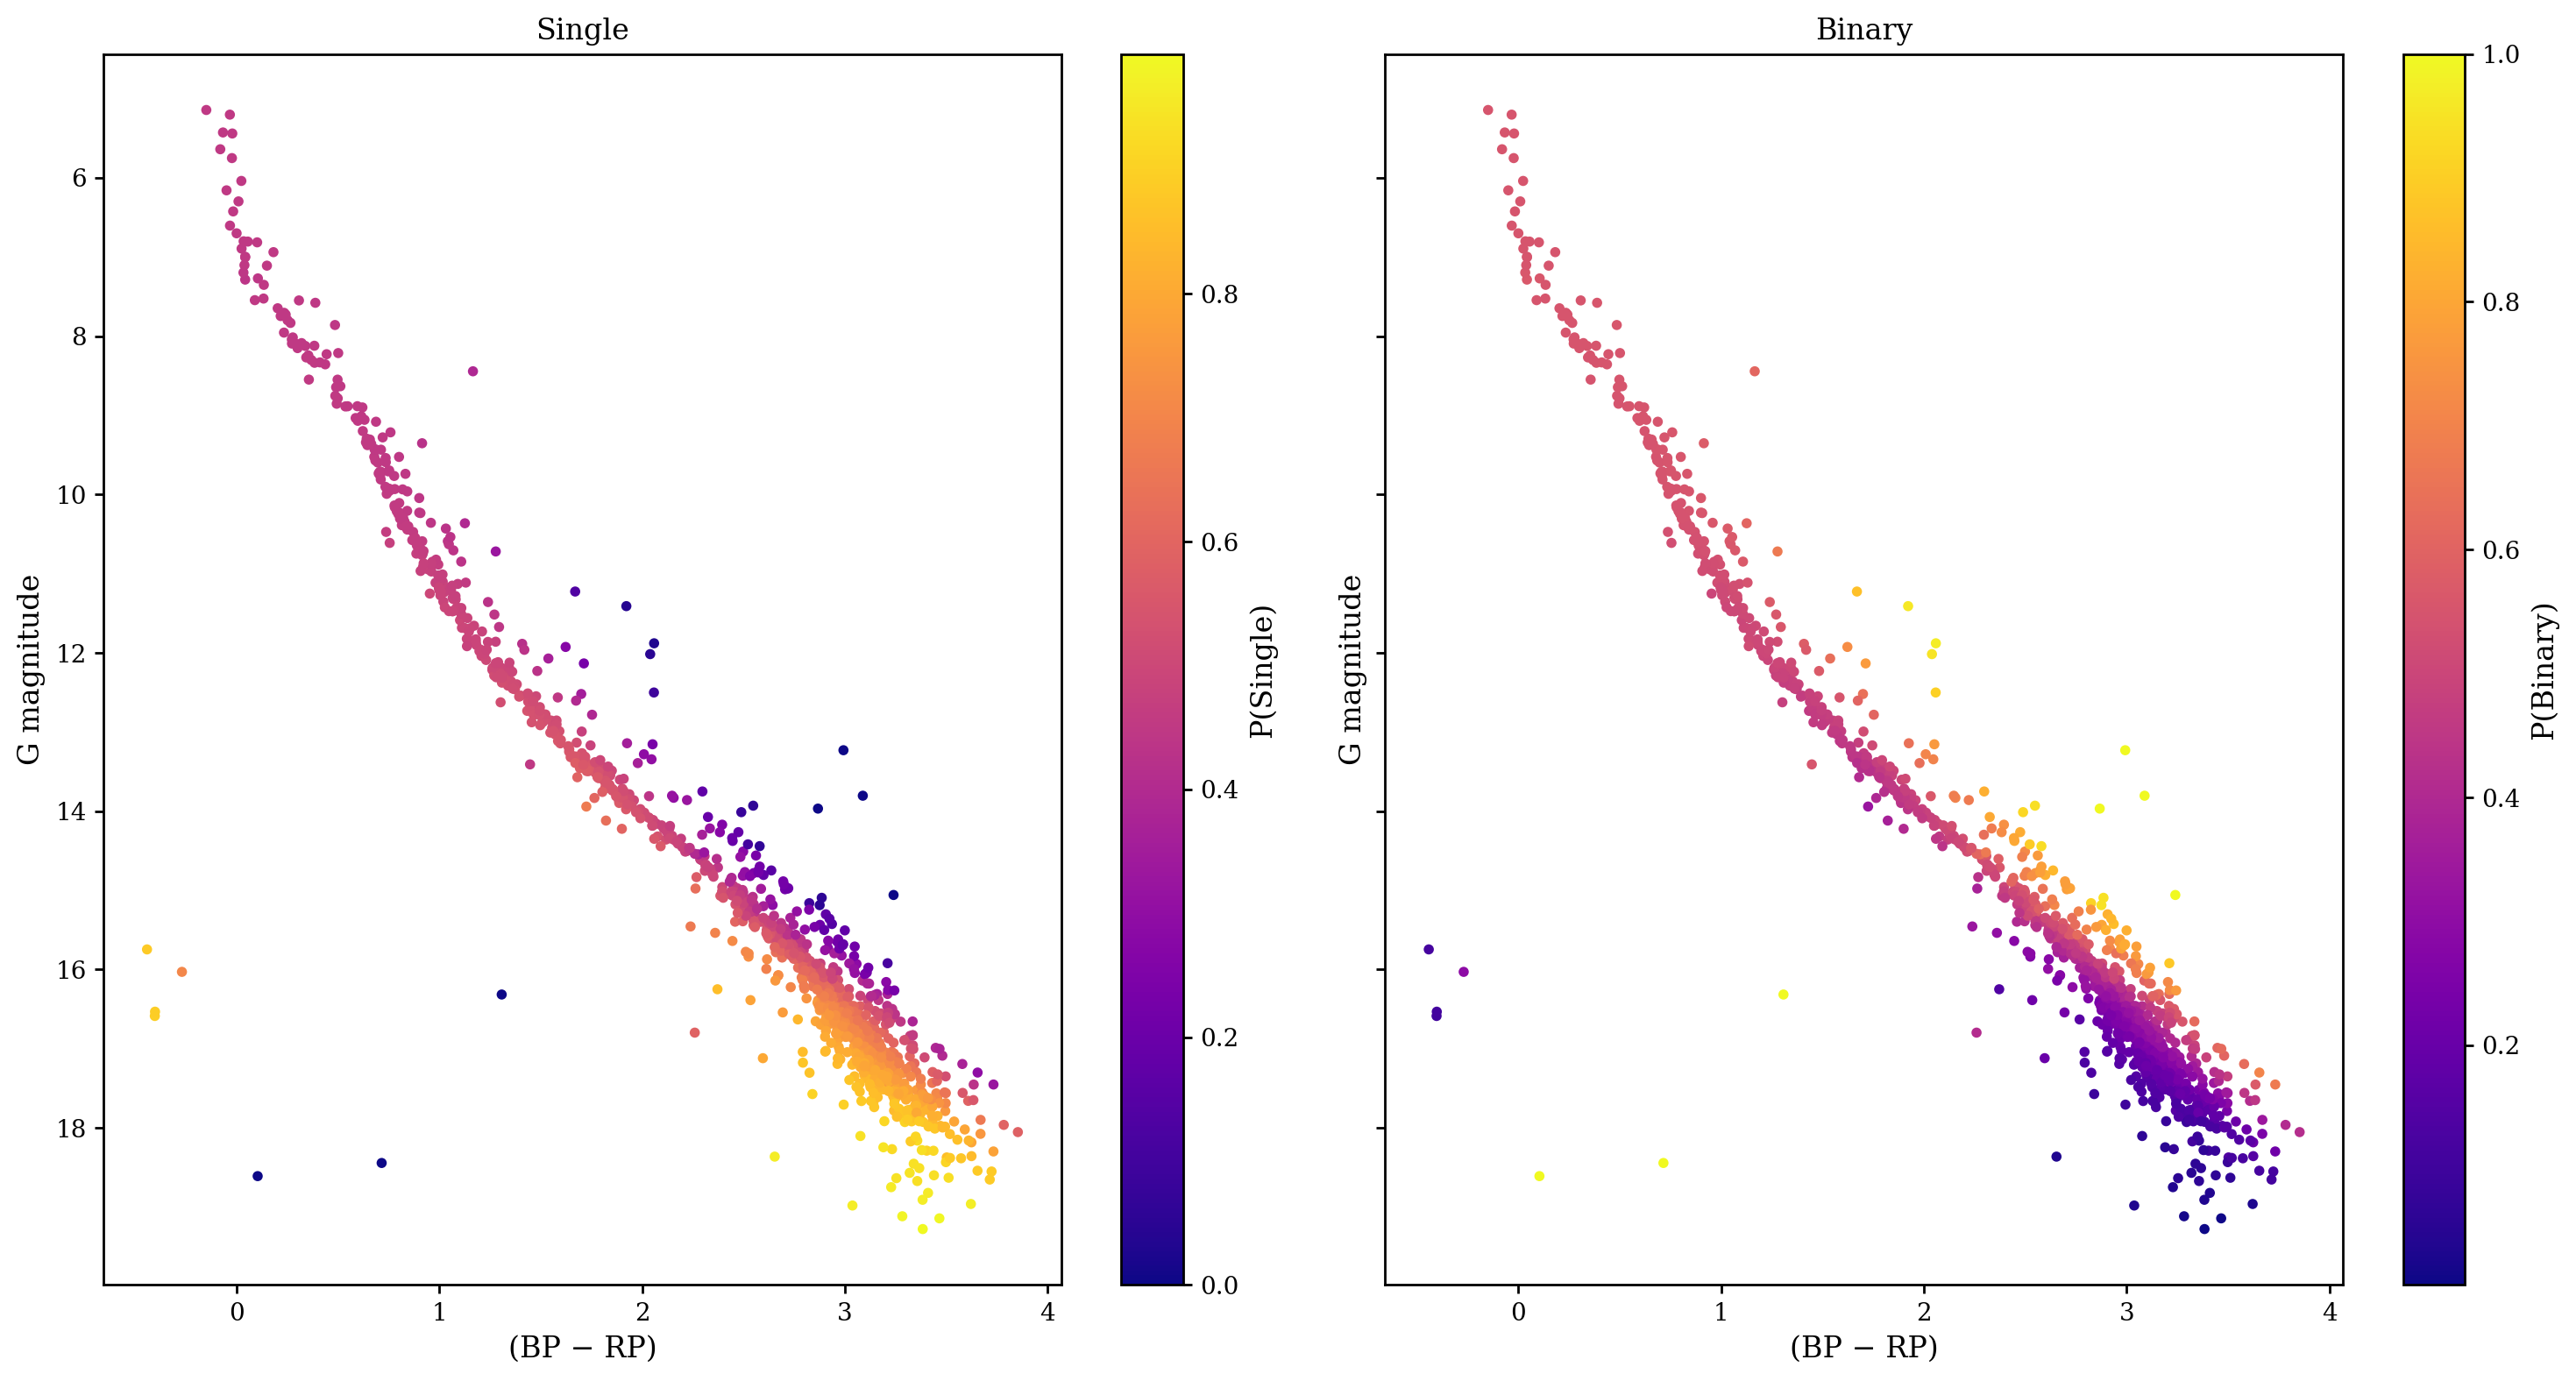

(<Figure size 1500x800 with 4 Axes>,
 array([<Axes: title={'center': 'Single'}, xlabel='(BP − RP)', ylabel='G magnitude'>,
        <Axes: title={'center': 'Binary'}, xlabel='(BP − RP)', ylabel='G magnitude'>],
       dtype=object))

In [43]:
# Let's see the probability distribution for each star now.
fieldless_fitter.plot()

Let's see if we can now quantify the uncertainty in the measurement.

In [ ]:
boot_stats = bootstrap_mixture_weights(fieldless_fitter, fitter.get_best_model(), n_boot=20)

logging.info(f"Bootstrap mean: {boot_stats['mean']}")
logging.info(f"Bootstrap std: {boot_stats['std']}")
logging.info(f"68% intervals: {boot_stats['ci68']}")

2025-11-17 17:24:34,281 - INFO - Starting EM fit
2025-11-17 17:24:34,282 - INFO - Initial weights: [0.57816572 0.42183428]
100%|██████████| 40/40 [00:04<00:00,  8.21it/s]
2025-11-17 17:24:39,155 - INFO - Final mixture weights: [0.57790091 0.42209909]
2025-11-17 17:24:39,157 - INFO - Starting EM fit
2025-11-17 17:24:39,157 - INFO - Initial weights: [0.57816572 0.42183428]
100%|██████████| 40/40 [00:04<00:00,  8.40it/s]
2025-11-17 17:24:43,923 - INFO - Final mixture weights: [0.57141595 0.42858405]
2025-11-17 17:24:43,925 - INFO - Starting EM fit
2025-11-17 17:24:43,926 - INFO - Initial weights: [0.57816572 0.42183428]
100%|██████████| 40/40 [00:04<00:00,  8.76it/s]
2025-11-17 17:24:48,491 - INFO - Final mixture weights: [0.58610802 0.41389198]
2025-11-17 17:24:48,493 - INFO - Starting EM fit
2025-11-17 17:24:48,493 - INFO - Initial weights: [0.57816572 0.42183428]
100%|██████████| 40/40 [00:04<00:00,  8.69it/s]
2025-11-17 17:24:53,098 - INFO - Final mixture weights: [0.5809104 0.4190896

To inspect how well the model did, let's compare the probabilities that the stars are binaries to a known catalog made by Chulkov et al. (2025) on resolving binaries using interferometry.

2025-11-17 17:11:51,862 - ERROR - Oops! Source ID 66486510358371072 not found in dataset.
2025-11-17 17:11:51,971 - ERROR - Oops! Source ID 65282716922610944 not found in dataset.
2025-11-17 17:11:52,506 - ERROR - Oops! Source ID 65272821318002560 not found in dataset.
2025-11-17 17:11:52,613 - ERROR - Oops! Source ID 66939848447027584 not found in dataset.
2025-11-17 17:11:52,824 - ERROR - Oops! Source ID 66507469798631936 not found in dataset.
2025-11-17 17:11:53,035 - ERROR - Oops! Source ID 65249250535404928 not found in dataset.
2025-11-17 17:11:53,348 - ERROR - Oops! Source ID 66873435368674944 not found in dataset.
2025-11-17 17:11:53,455 - ERROR - Oops! Source ID 64814045795106944 not found in dataset.
2025-11-17 17:11:53,561 - ERROR - Oops! Source ID 65163797868281088 not found in dataset.
2025-11-17 17:11:53,666 - ERROR - Oops! Source ID 66814302260735104 not found in dataset.
2025-11-17 17:11:53,970 - ERROR - Oops! Source ID 66733552578791296 not found in dataset.
2025-11-17

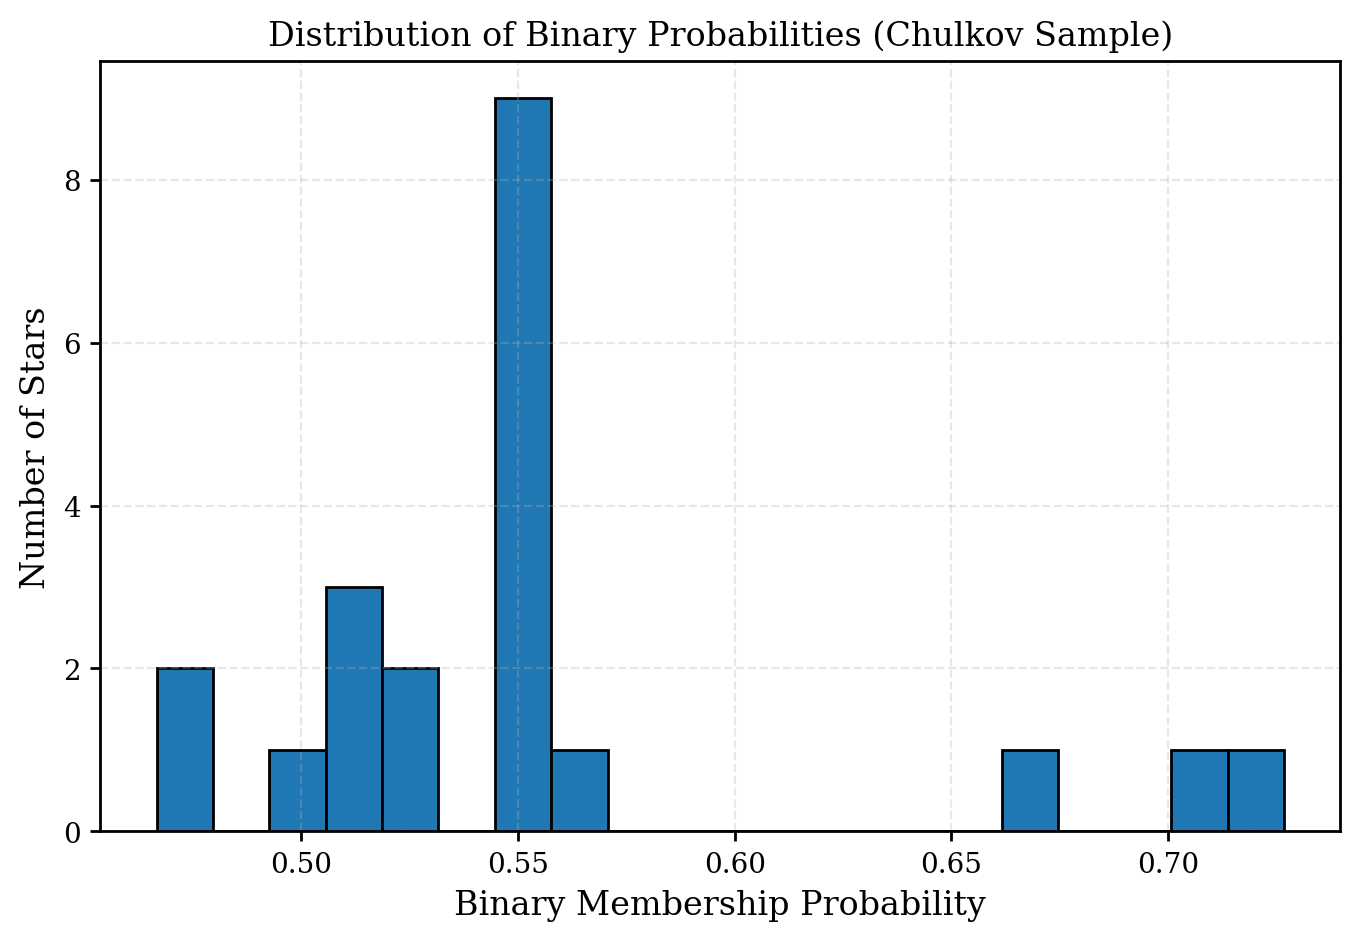

In [31]:
# Load list of sources
chulkov_df = pd.read_csv('data/chulkov_binaries.csv')
chulkov_source_ids = chulkov_df['Gaia1'].astype(str)

binary_probs = []
for source_id in chulkov_source_ids:
    try:
        probs = fieldless_fitter.get_probability(source_id)
        p_binary = probs["binary"]
        binary_probs.append(p_binary)
    except ValueError as e:
        logging.error(f"Oops! {e}")

binary_probs = np.array(binary_probs)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(binary_probs, bins=20, edgecolor='black')
plt.xlabel("Binary Membership Probability")
plt.ylabel("Number of Stars")
plt.title("Distribution of Binary Probabilities (Chulkov Sample)")
plt.grid(alpha=0.3, linestyle='--')
plt.show()

We can also inspect using TESS short cadence variability data - notably, cross matching to see if any of the binaries in the Eclipsing Binary Catalog are also high probability.

In [14]:
# Only extract light curves of relevant TESS data for now.
lightcurve_analyzer = LightCurveExtractor(download_dir='lightcurves/')

ids = gaia_analyzer.extract_source_ids()
lightcurves = lightcurve_analyzer.extract_eb_lightcurves(ids)

2025-11-17 16:41:06,998 - INFO - Set Lightkurve download directory to lightcurves/
2025-11-17 16:41:07,000 - INFO - Using cached TESS EB catalog at data/tess_eb_catalog.csv
2025-11-17 16:41:34,453 - WARNING - No TIC match for 3 Gaia IDs: [67680850564641792, 70190249631846272, 52035251073077120]...
  0%|          | 0/1276 [00:00<?, ?it/s]2025-11-17 16:41:34,454 - INFO - Inspecting for EB membership: Gaia 3763976194792448 -> TIC 377056867
2025-11-17 16:41:34,454 - INFO - Inspecting for EB membership: Gaia 11352324413414016 -> TIC 416678539
2025-11-17 16:41:34,455 - INFO - Inspecting for EB membership: Gaia 19817739313090688 -> TIC 620010441
2025-11-17 16:41:34,455 - INFO - Inspecting for EB membership: Gaia 43733079289895424 -> TIC 434162270
2025-11-17 16:41:34,455 - INFO - Inspecting for EB membership: Gaia 46438771249859840 -> TIC 456886532
2025-11-17 16:41:34,456 - INFO - Inspecting for EB membership: Gaia 46922075328601216 -> TIC 15938971
2025-11-17 16:41:34,456 - INFO - Inspecting f

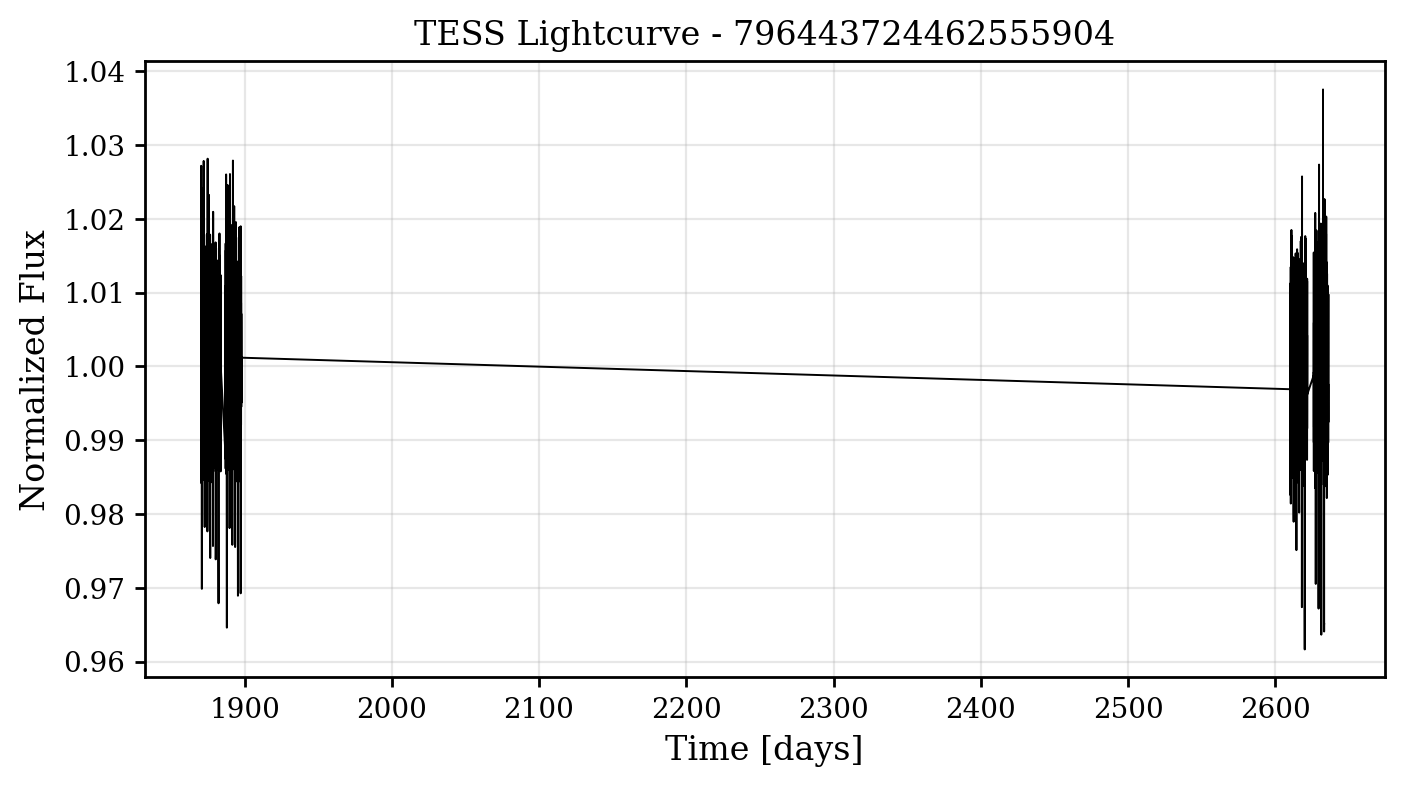

In [15]:
# You'll notice that we only should have one light curve here.
tess_analyzer = TESSAnalyzer(lightcurves=lightcurves)
tess_analyzer.batch_plot()

2025-11-17 16:41:56,497 - INFO - Analyzing lightcurve for 796443724462555904


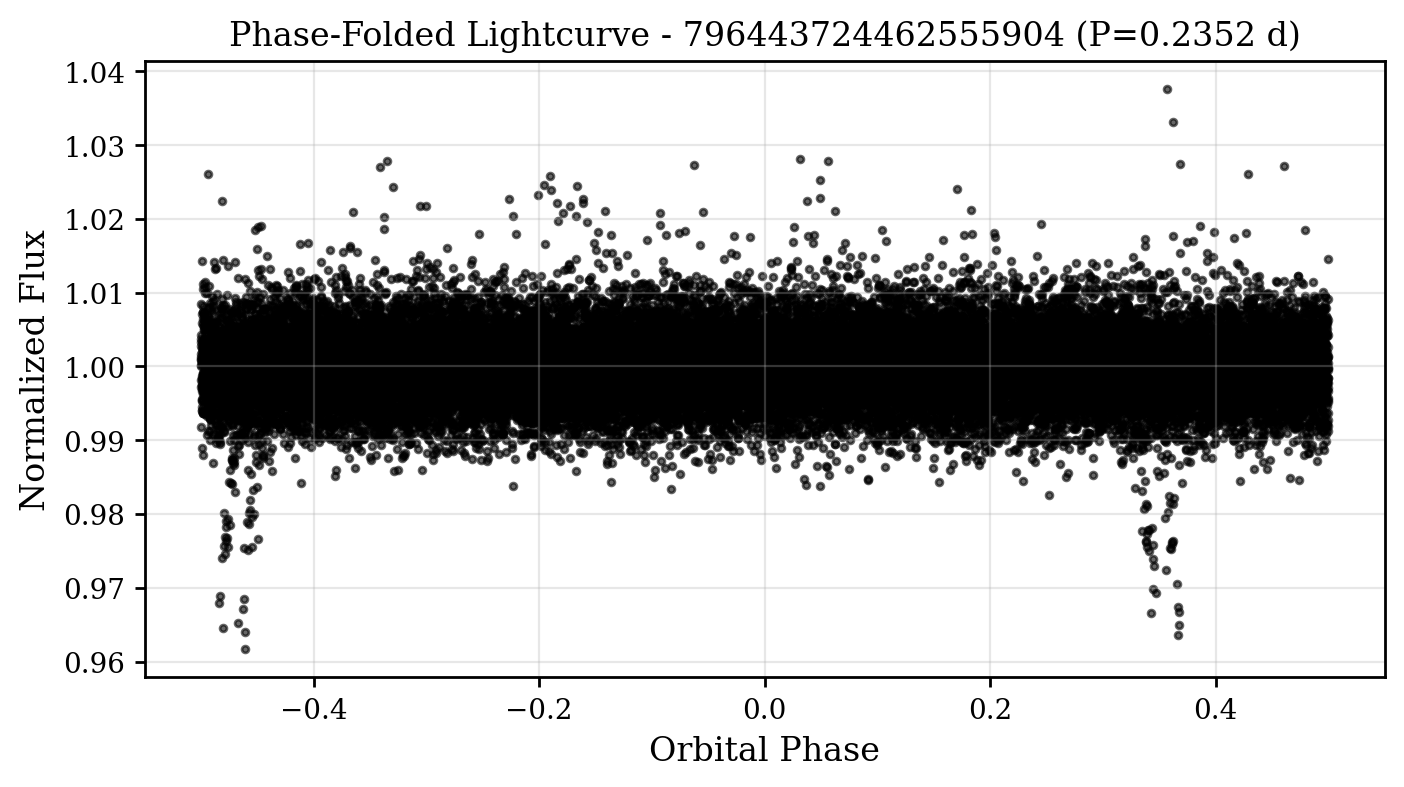

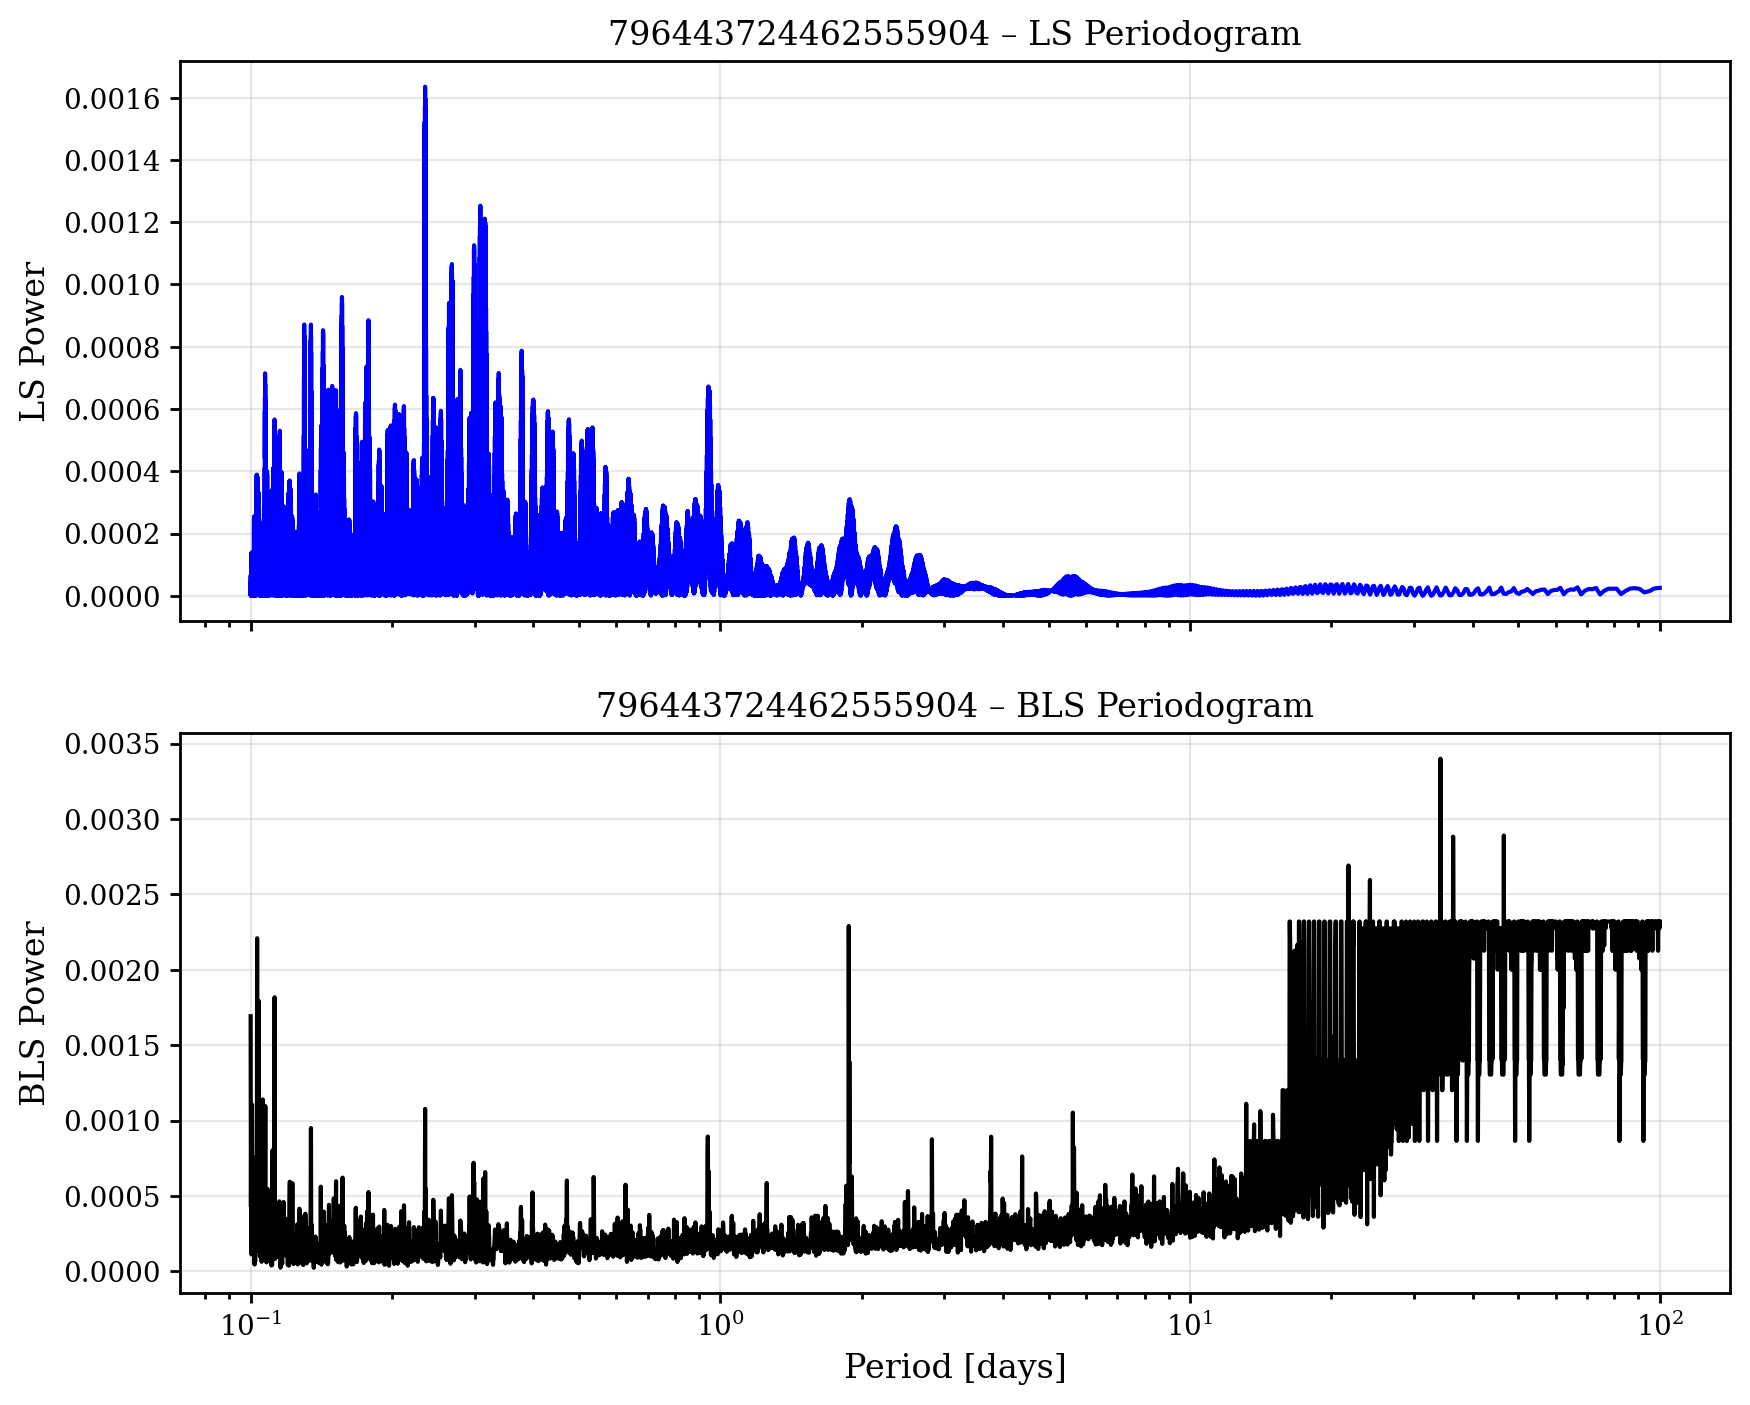

In [16]:
# Let's analyze all of the light curves (just one) simultaneously and plot the periodogram to confirm that this is an eclipsing binary.
results = tess_analyzer.batch_analyze()
tess_analyzer.batch_plot_folded()
tess_analyzer.batch_plot_periodograms()

### Part 3: Synthetic Populations
Now that we've tested it out on real data, let's do synthetic data to see how well our model fares (this is the reverse order of how these experiments typically work!) Let's generate a synthetic cluster using the `isochrones` package and see how well our fit code fares.

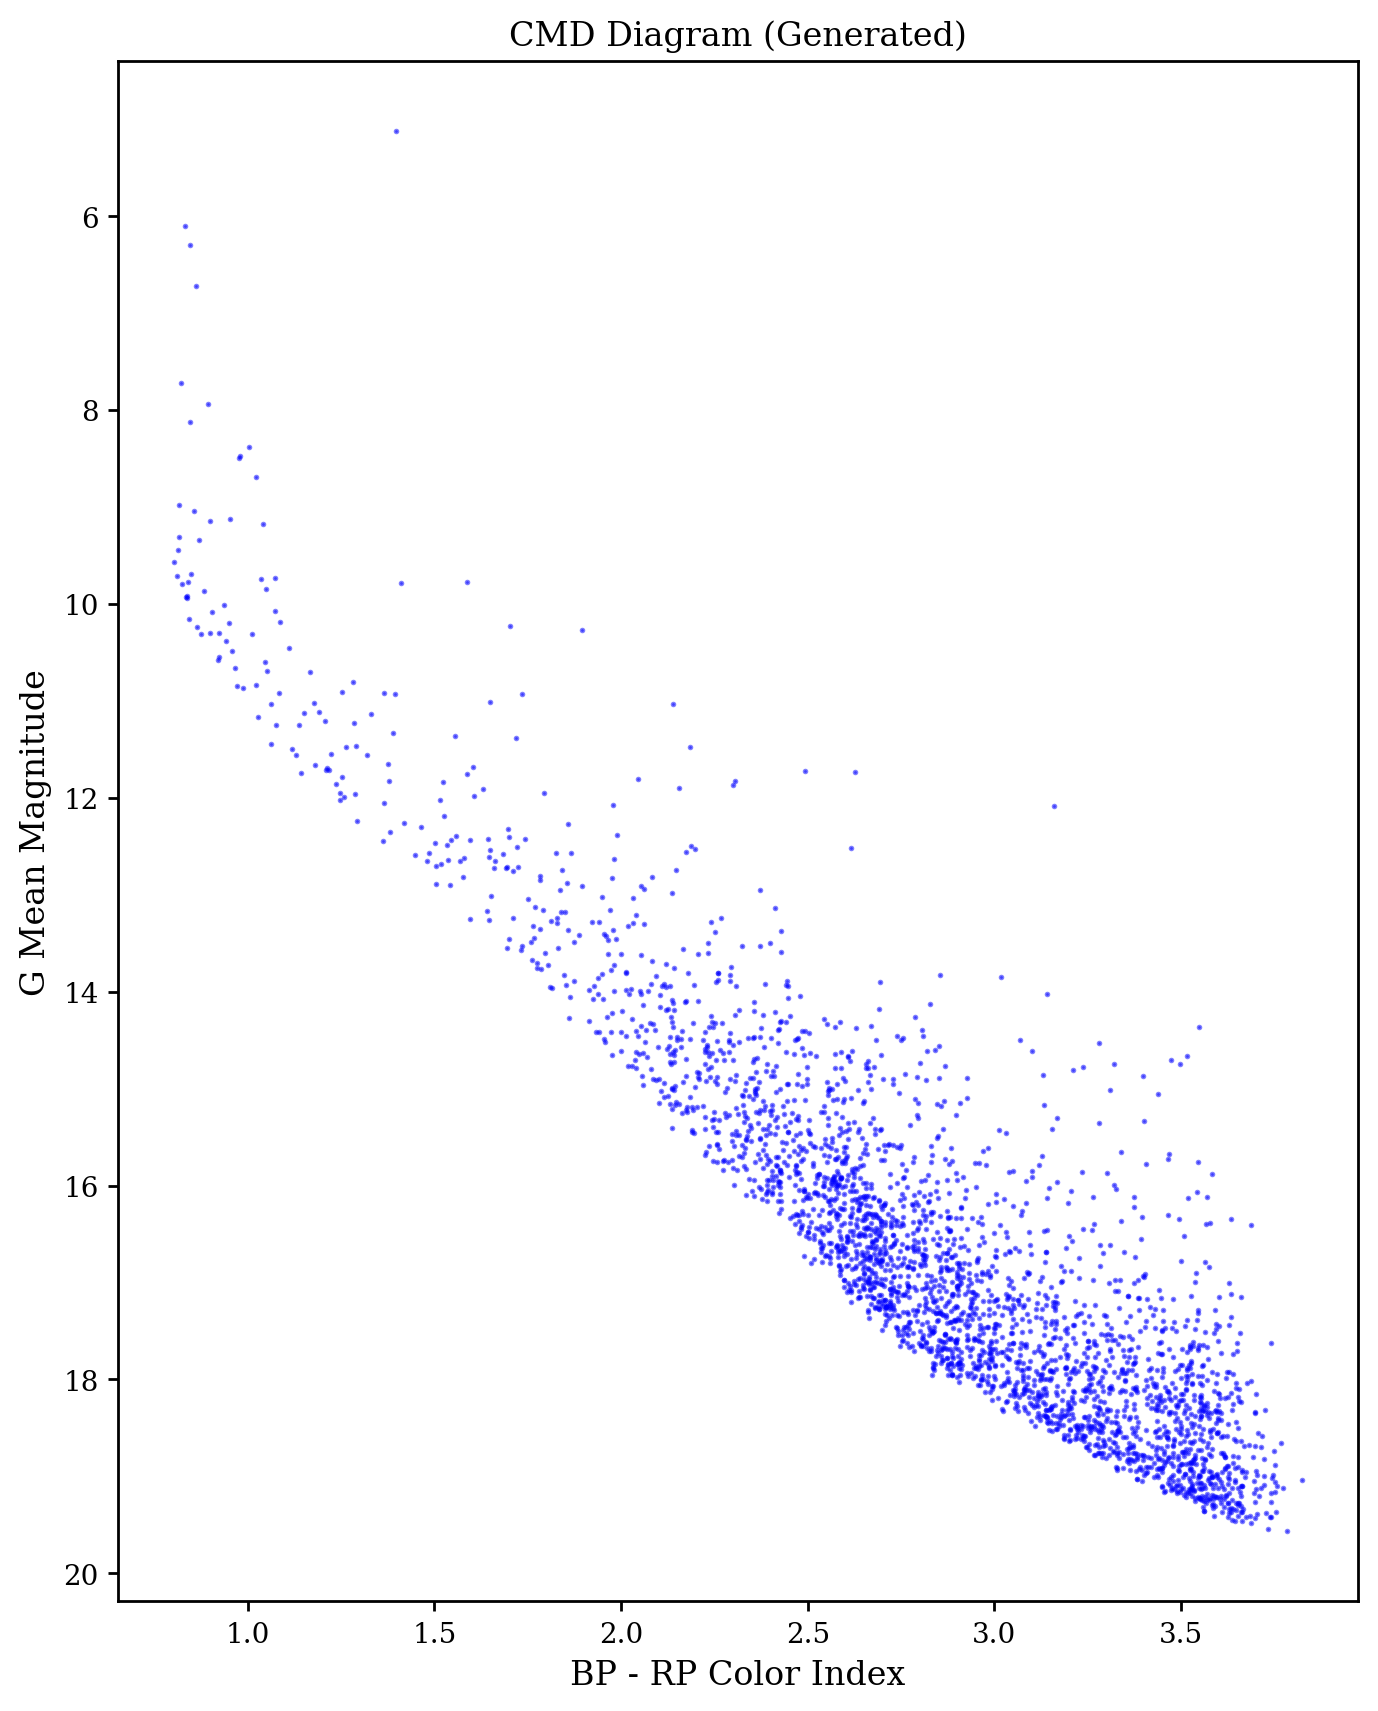

(<Figure size 800x1000 with 1 Axes>,
 <Axes: title={'center': 'CMD Diagram (Generated)'}, xlabel='BP - RP Color Index', ylabel='G Mean Magnitude'>)

In [32]:
# Let's design an isochrone synthesizer and generate 1000 points.

synthesizer = IsochroneSynthesizer(fB=0.4)
synthetic_df = synthesizer.generate(3000)
synthesizer.plot_hr_diagram(n=3000)

In [33]:
# Repeat the same steps as Part 1.
synthetic_fitter = MISTFitter(data=synthetic_df)
synthetic_sampler = synthetic_fitter.sample_cluster(n_walkers=32, n_burn=200, n_steps=1000)
synthetic_fitter.plot_corner(synthetic_sampler, discard=200, thin=200)

100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]


KeyboardInterrupt: 

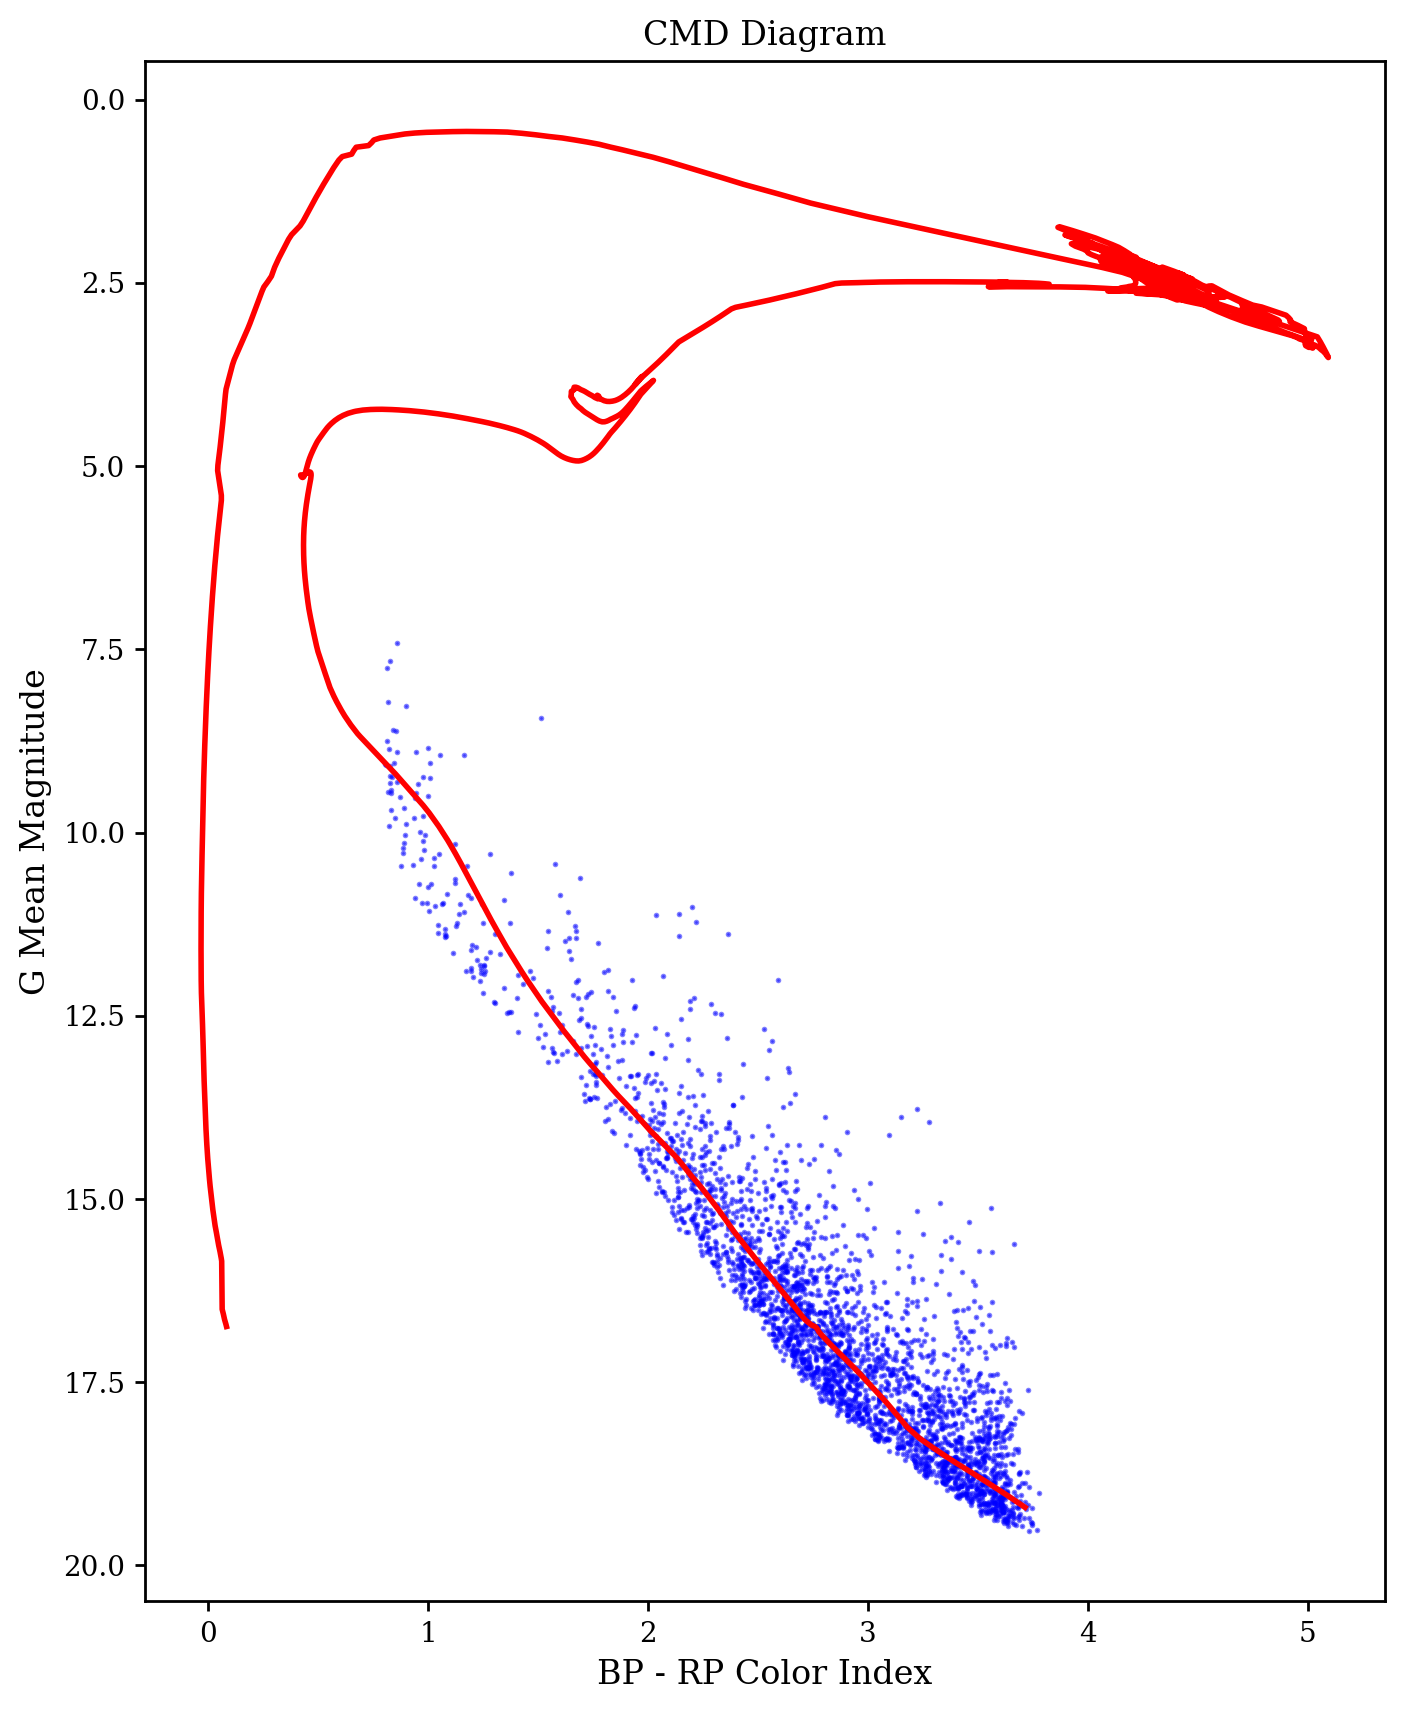

90.89506651023319


In [19]:
# We get the best parameters here too
synthetic_best_params = synthetic_fitter.get_best_model()
synthetic_fitter.plot_isochrone(synthetic_best_params)

print(synthetic_fitter.bic())

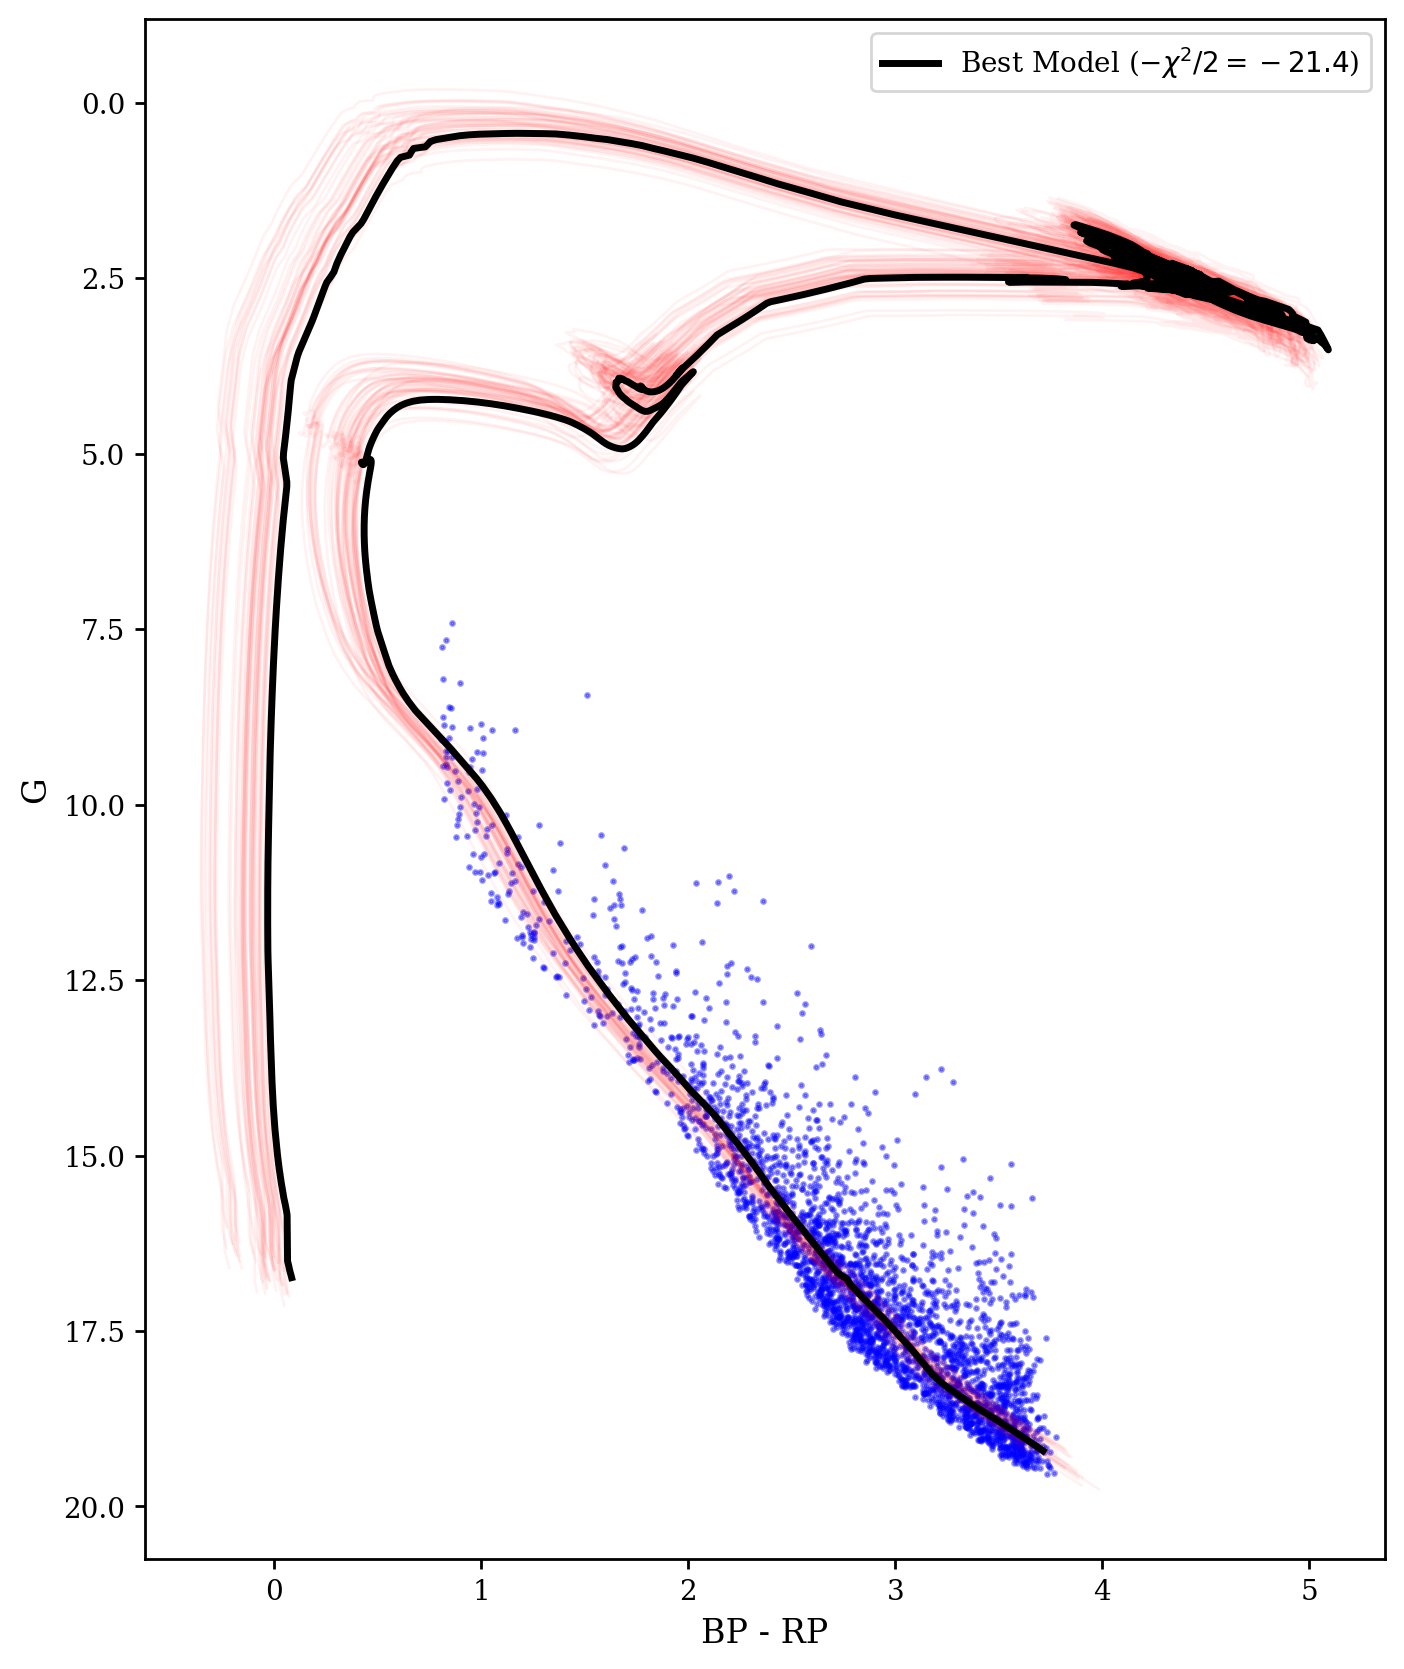

(<Figure size 800x1000 with 1 Axes>, <Axes: xlabel='BP - RP', ylabel='G'>)

In [20]:
# Let's also show the synthetic best fits as well!
synthetic_fitter.plot_good_isochrones(chi2_cutoff=1)

2025-11-17 16:51:32,298 - INFO - Starting EM fit
2025-11-17 16:51:32,299 - INFO - Initial weights: [0.8 0.2 0. ]
100%|██████████| 40/40 [00:10<00:00,  3.86it/s]
2025-11-17 16:51:42,664 - INFO - Final mixture weights: [0.24277647 0.30184054 0.45538299]


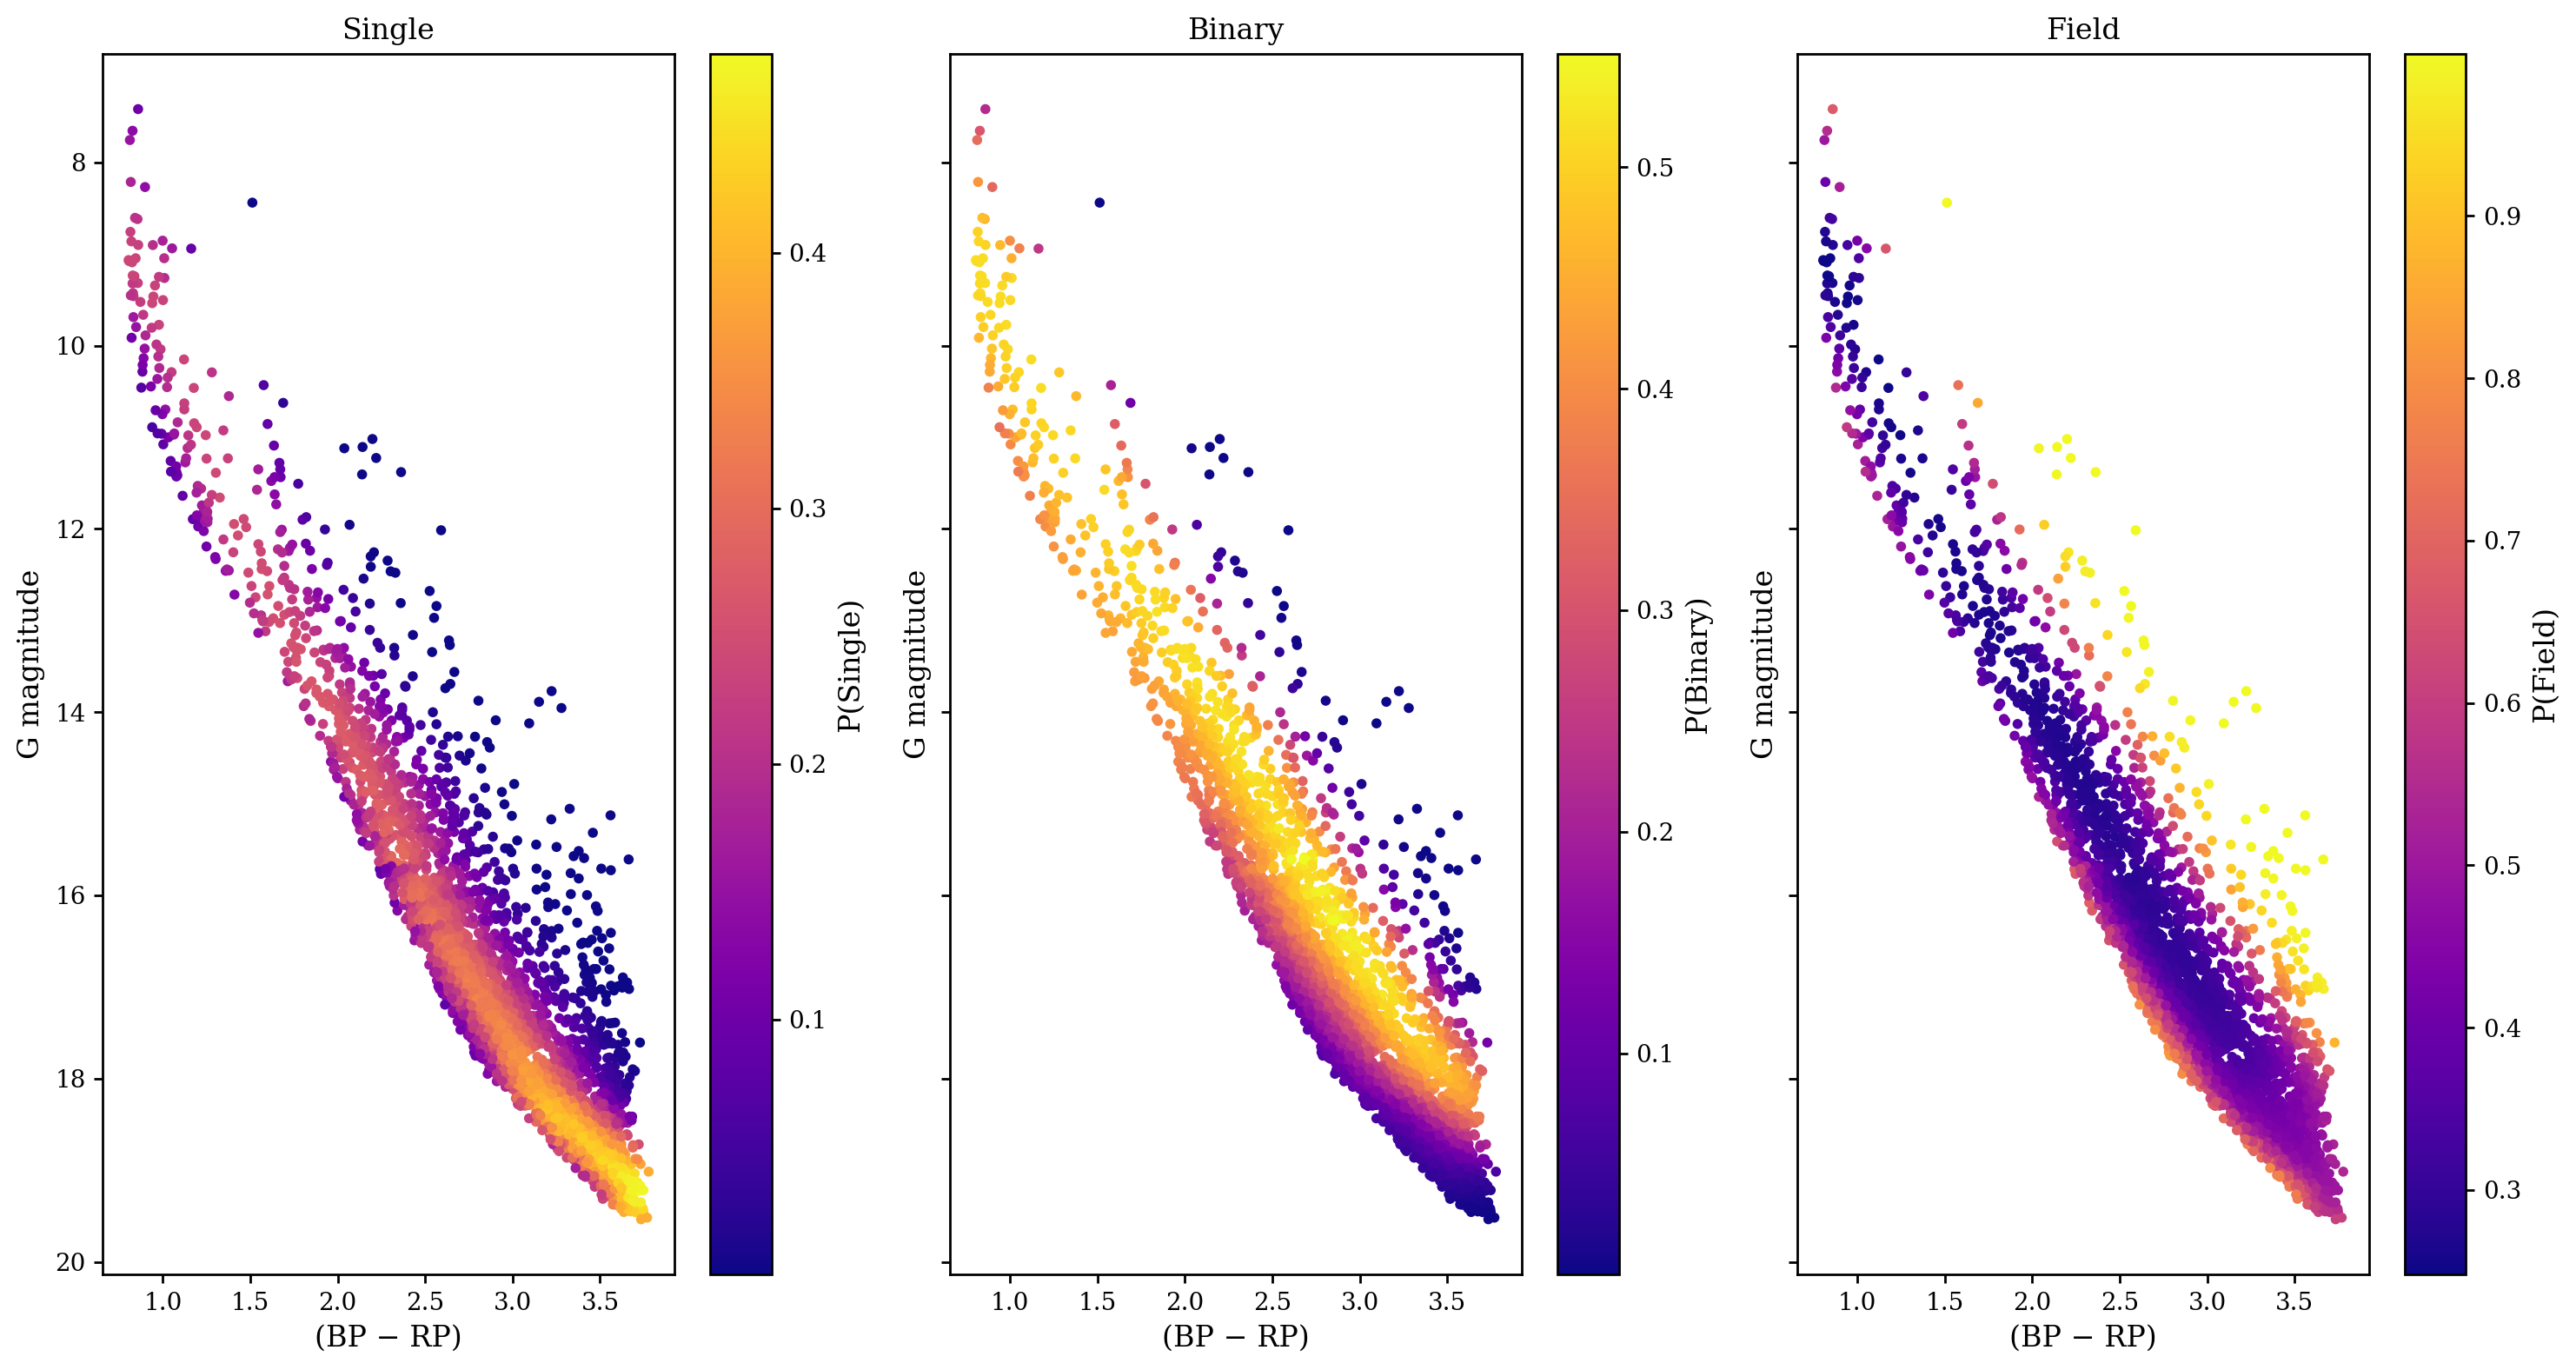

2025-11-17 16:51:43,296 - INFO - The optimal fit weights for the synthetic population are: [f_single, f_binary, f_field] = [0.24277647 0.30184054 0.45538299]


In [21]:
# Use the previous single star isochrone fit as a prior to inform the binary mixture fit.
synth_bfitter = BinaryMixtureFitter(data=synthetic_df)
synth_bfitter.fit(theta=synthetic_best_params)
synth_bfitter.plot()

logging.info(
    f"The optimal fit weights for the synthetic population are: [f_single, f_binary, f_field] = {synth_bfitter.get_mixture_weights()}"
)

2025-11-17 16:51:43,329 - INFO - Starting EM fit
2025-11-17 16:51:43,329 - INFO - Initial weights: [0.8 0.2]
100%|██████████| 40/40 [00:09<00:00,  4.05it/s]
2025-11-17 16:51:53,197 - INFO - Final mixture weights: [0.45308965 0.54691035]


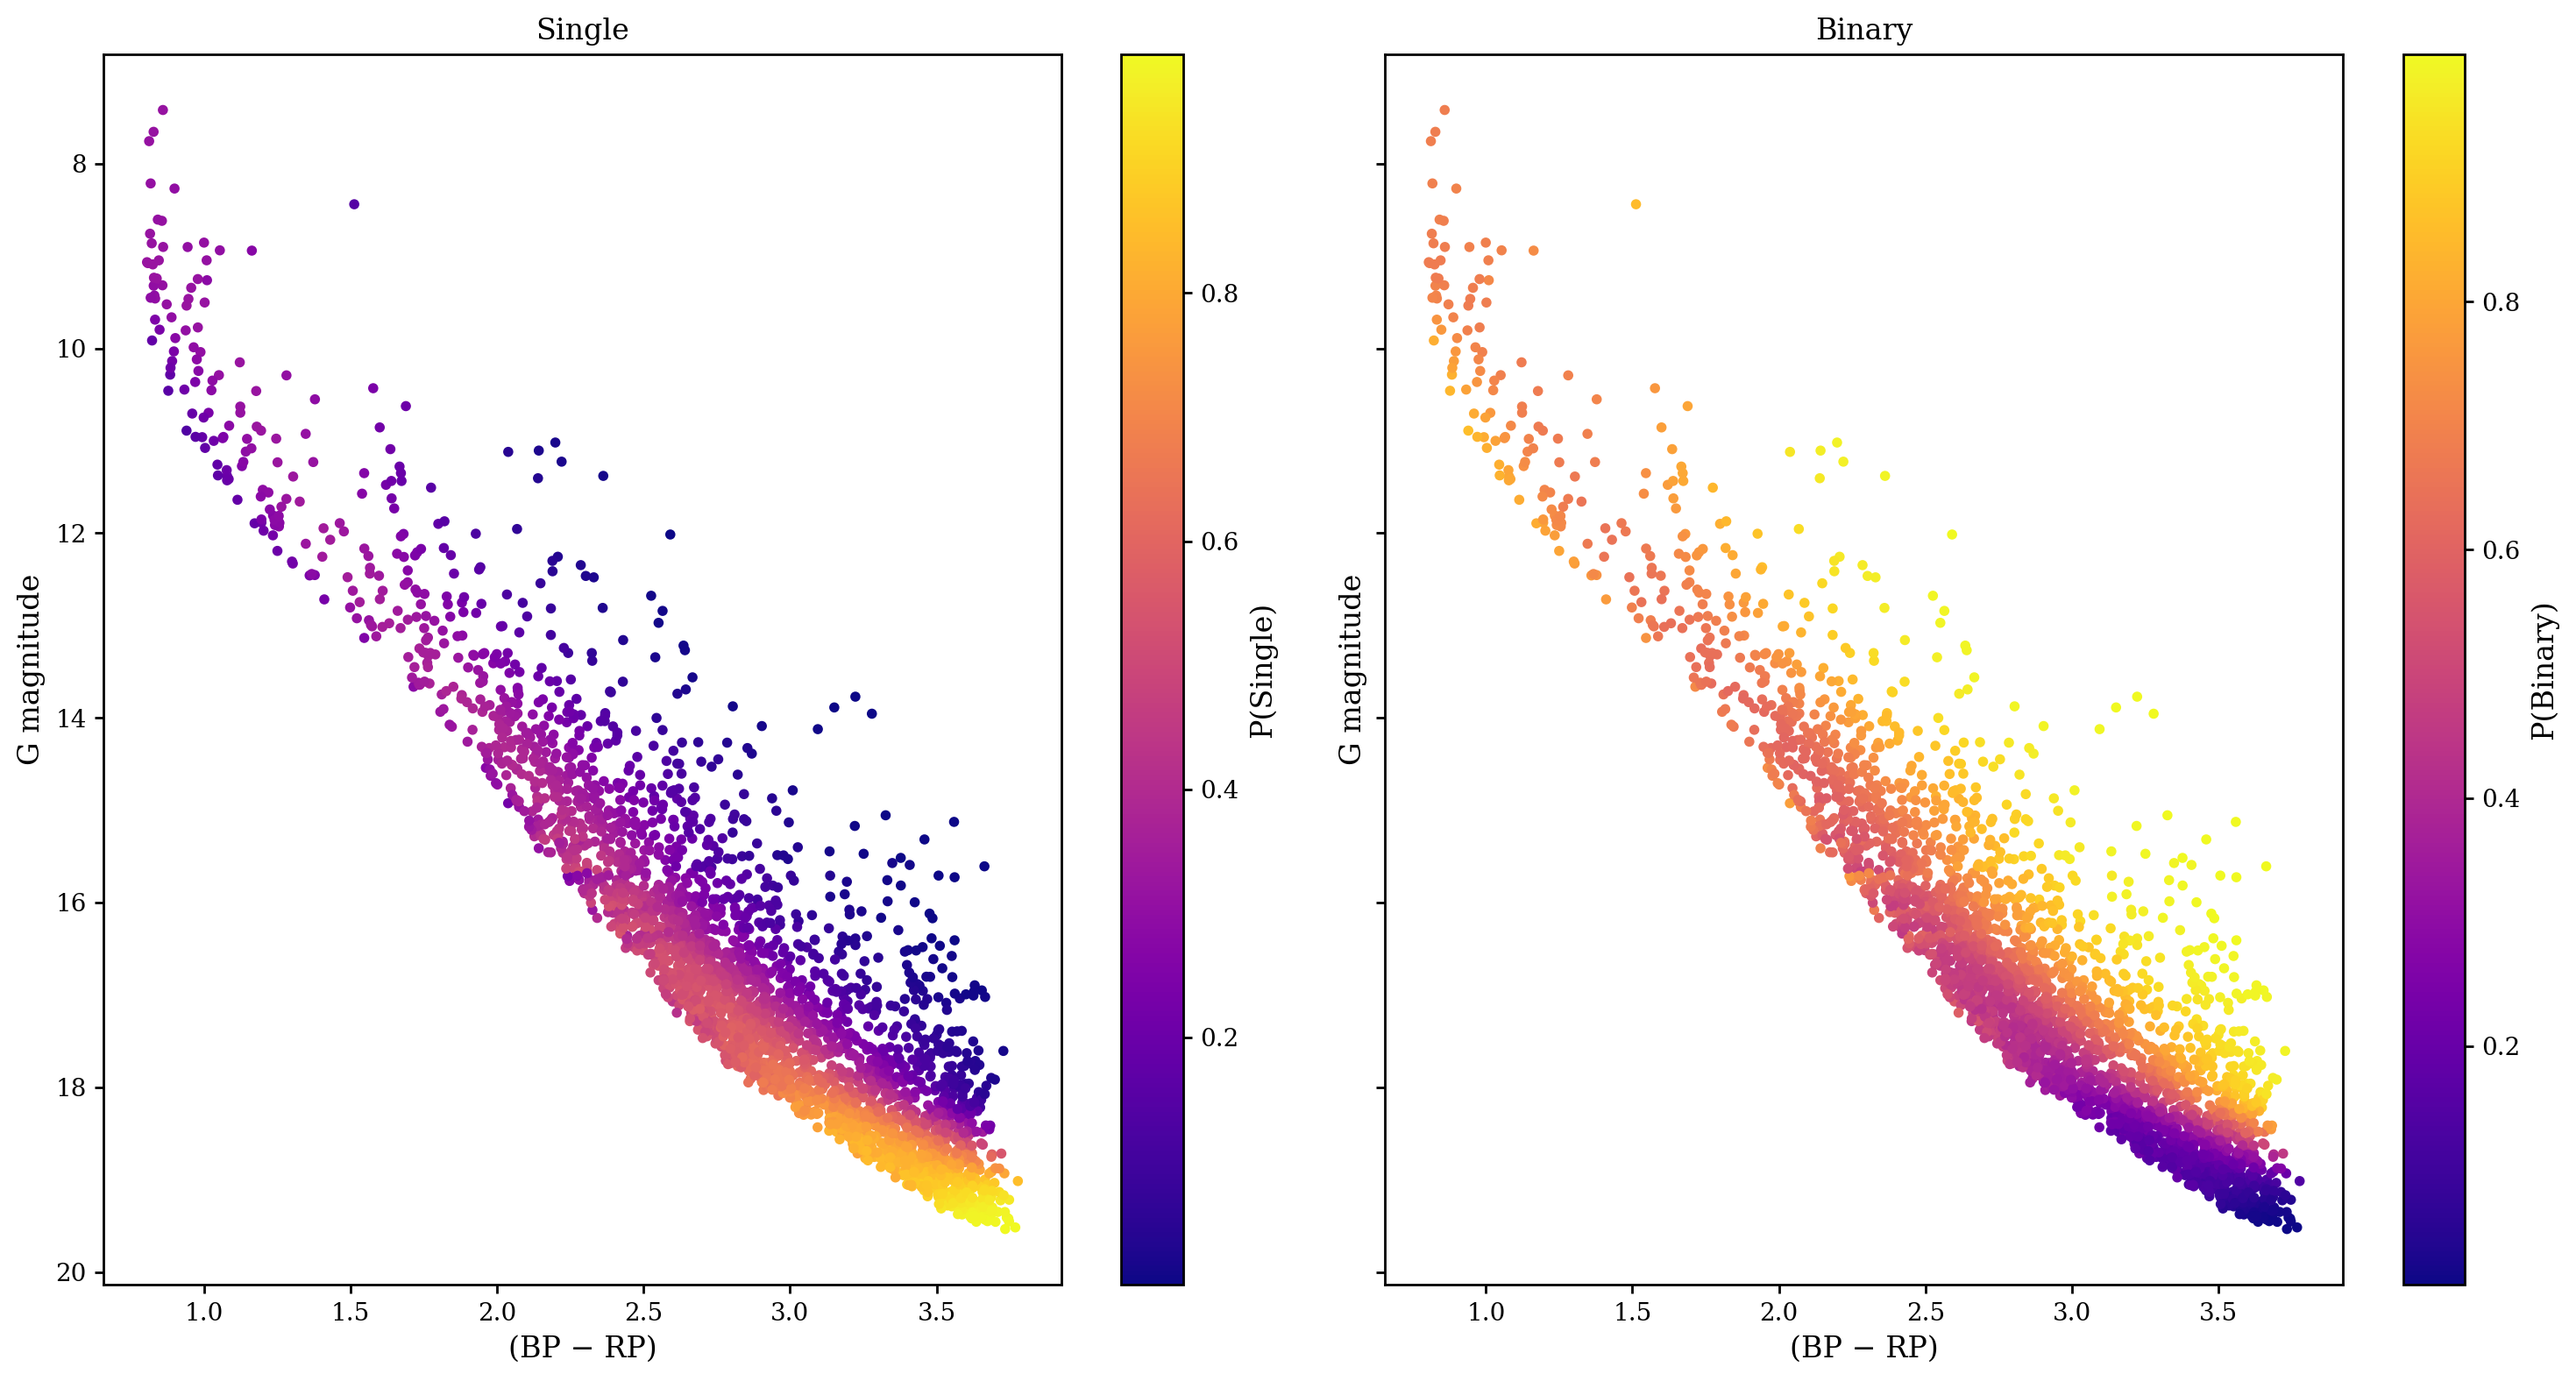

2025-11-17 16:51:53,822 - INFO - The optimal fit weights for the synthetic population are: [f_single, f_binary] = [0.45308965 0.54691035]


In [22]:
# This time, no field.
synth_fieldless_bfitter = BinaryMixtureFitter(data=synthetic_df, use_field=False)
synth_fieldless_bfitter.fit(theta=synthetic_best_params)
synth_fieldless_bfitter.plot()

logging.info(
    f"The optimal fit weights for the synthetic population are: [f_single, f_binary] = {synth_fieldless_bfitter.get_mixture_weights()}"
)

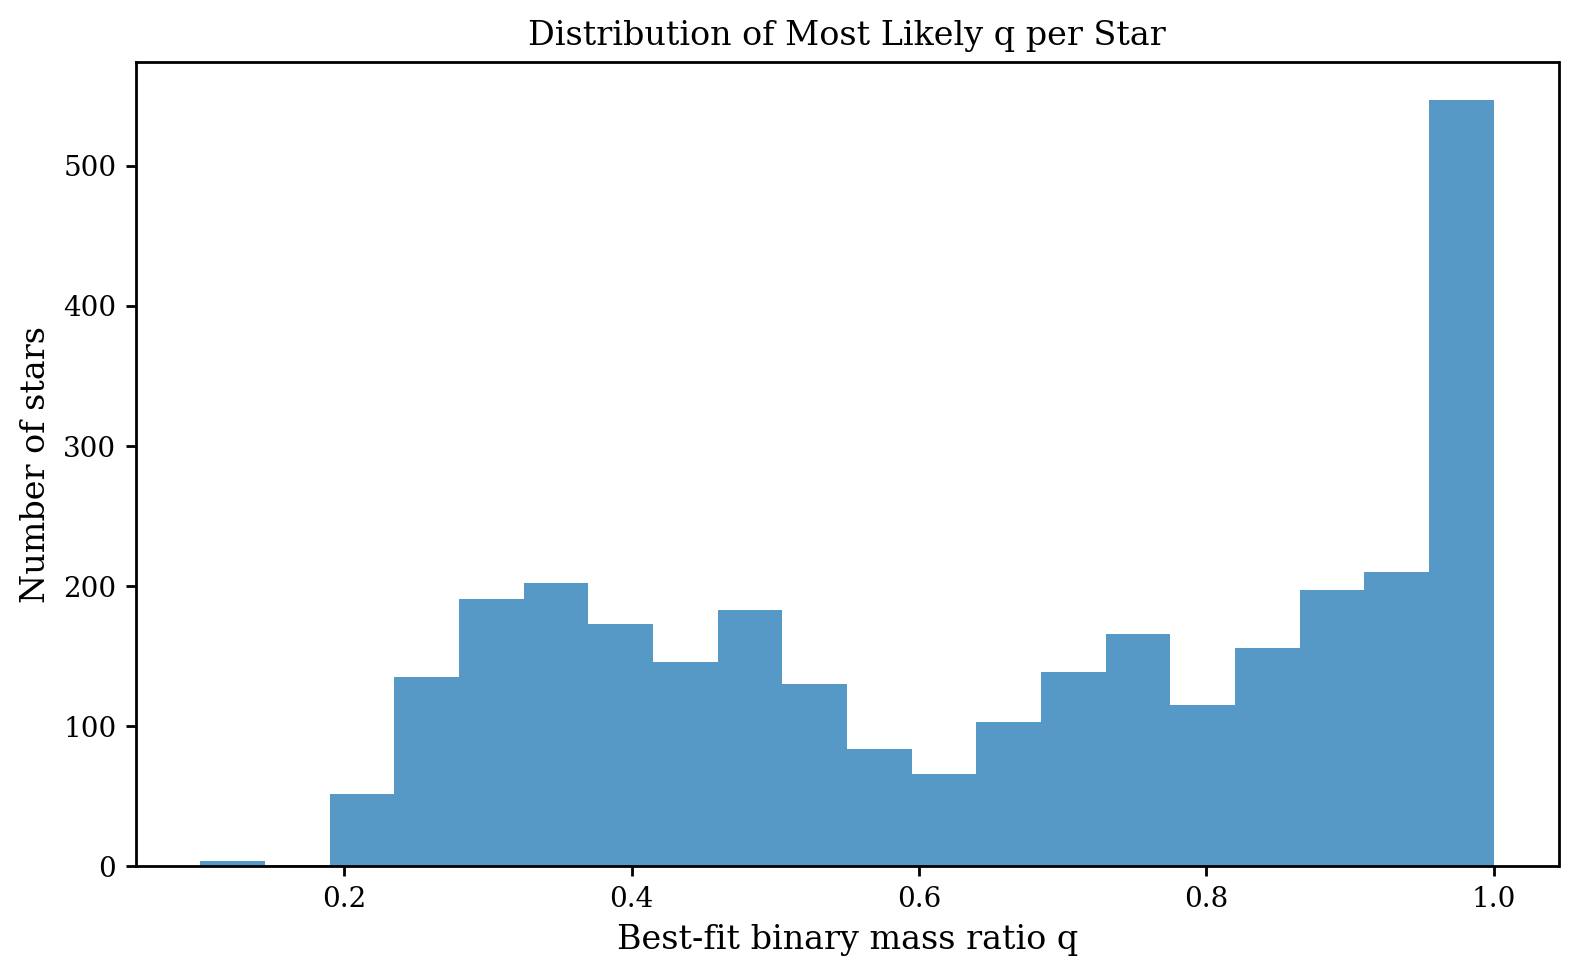

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Most Likely q per Star'}, xlabel='Best-fit binary mass ratio q', ylabel='Number of stars'>)

In [23]:
# We can also get the preedicted mass ratios, q, per star.
synth_fieldless_bfitter.plot_qs()